In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs

def generate_classification_data(samples=100, features=2, informative=2, redundant=0, classes=2, random_state=None):
    """
    Generate synthetic classification data.
    """
    X, y = make_classification(
        n_samples=samples,
        n_features=features,
        n_informative=informative,
        n_redundant=redundant,
        n_classes=classes,
        random_state=random_state
    )
    return X, y

def generate_moons_data(samples=100, noise=0.1, random_state=None):
    """
    Generate synthetic moon-shaped data.
    """
    X, y = make_moons(n_samples=samples, noise=noise, random_state=random_state)
    return X, y

def generate_circles_data(samples=100, noise=0.1, factor=0.8, random_state=None):
    """
    Generate synthetic circular data.
    """
    X, y = make_circles(n_samples=samples, noise=noise, factor=factor, random_state=random_state)
    return X, y

def generate_blobs_data(samples=100, centers=2, features=2, cluster_std=1.0, random_state=None):
    """
    Generate synthetic blob data.
    """
    X, y = make_blobs(
        n_samples=samples,
        centers=centers,
        n_features=features,
        cluster_std=cluster_std,
        random_state=random_state
    )
    # Adjust labels to binary for 2-class problems
    if centers == 2:
        y = np.where(y == 0, 0, 1)
    return X, y

# Wrapper to generate datasets
def generate_datasets():
    datasets = {
        "Linear Separable": generate_classification_data(samples=500, features=2, informative=2, random_state=42),
        "Moons": generate_moons_data(samples=500, noise=0.2, random_state=42),
        "Circles": generate_circles_data(samples=500, noise=0.1, random_state=42),
        "Blobs": generate_blobs_data(samples=500, centers=2, features=2, random_state=42)
    }
    return datasets


def generate_grid_data(grid_size=50, noise=0.1, random_state=42):
    """
    - grid_size: The number of points along each axis (grid_size x grid_size points total).
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Create a regular grid of points
    x = np.linspace(-1, 1, grid_size) * 3
    y = np.linspace(-1, 1, grid_size) * 3
    xx, yy = np.meshgrid(x, y)
    
    # Flatten the grid to create coordinate pairs
    X = np.c_[xx.ravel(), yy.ravel()]
    
    # Add noise to the grid points
    X += noise * np.random.randn(*X.shape)
    
    # Generate labels based on distance from the origin (e.g., circular decision boundary)
    y = np.random.randint(0, 2, size=X.shape[0])
    
    return X, y


In [2]:
#ALTERNATIVE

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

In [3]:
### VISUALIZATION OF DECISION BOUNDARY
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for the purpose of the task by Vladimir Lazarik
# License: BSD 3 clause

def default_plotter(datasets, names, classifiers, db=True, margins=False, plot_dims=(27,9)):
    # figure = plt.figure(figsize=(27, 9))
    figure = plt.figure(figsize=plot_dims)

    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )
        X_train = X
        y_train = y
    
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        # Plot the testing points
        # ax.scatter(
        #     X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        # )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1
    
        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            try:
                clf = make_pipeline(StandardScaler(), clf)
                clf.fit(X_train, y_train)
                score = clf.score(X_test, y_test)
                DecisionBoundaryDisplay.from_estimator(
                    clf, X, cmap=cm, alpha=0.6, ax=ax, eps=1, plot_method="contourf", response_method="predict" #pcolormesh
                )
        
                # Plot the training points
                ax.scatter(
                    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", alpha=0.7
                )
            
                # Assume overfitted on training data to show which datapoints generated the regions/boundaries
                # Plot the testing points
                # ax.scatter(
                #     X_test[:, 0],
                #     X_test[:, 1],
                #     c=y_test,
                #     cmap=cm_bright,
                #     edgecolors="k",
                #     alpha=0.6,
                # )

                if db: # decision boundary
                    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
                    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
                    Z = Z.reshape(XX.shape)

                    # if 'svc' in clf.named_steps and clf.named_steps['svc'].kernel == "linear":
                        # margin = 1 / np.sqrt(np.sum(clf.named_steps['svc'].coef_**2))                    
                    plt.contour(
                        XX,
                        YY,
                        Z,
                        colors=["k", "k", "k"],
                        linestyles=["--", "-", "--"],
                        levels=[-margin, 0, margin] if margins else [0]
                        # levels=[0] if not margins else [-0.5, 0, 0.5] 
                        # levels=[-0.5, 0, 0.5],
                    )

                    plt.scatter(
                        clf.support_vectors_[:, 0],
                        clf.support_vectors_[:, 1],
                        s=180,
                        facecolors="none",
                        zorder=10,
                        edgecolors="k",
                    )
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                ax.set_xticks(())
                ax.set_yticks(())
            except Exception as e:
                pass
            if ds_cnt == 0:
                ax.set_title(name)
            # Uncomment to display score in lower right corner
            # ax.text(
            #     x_max - 0.3,
            #     y_min + 0.3,
            #     ("%.2f" % score).lstrip("0"),
            #     size=15,
            #     horizontalalignment="right",
            # )
            i += 1
    
    plt.tight_layout()
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

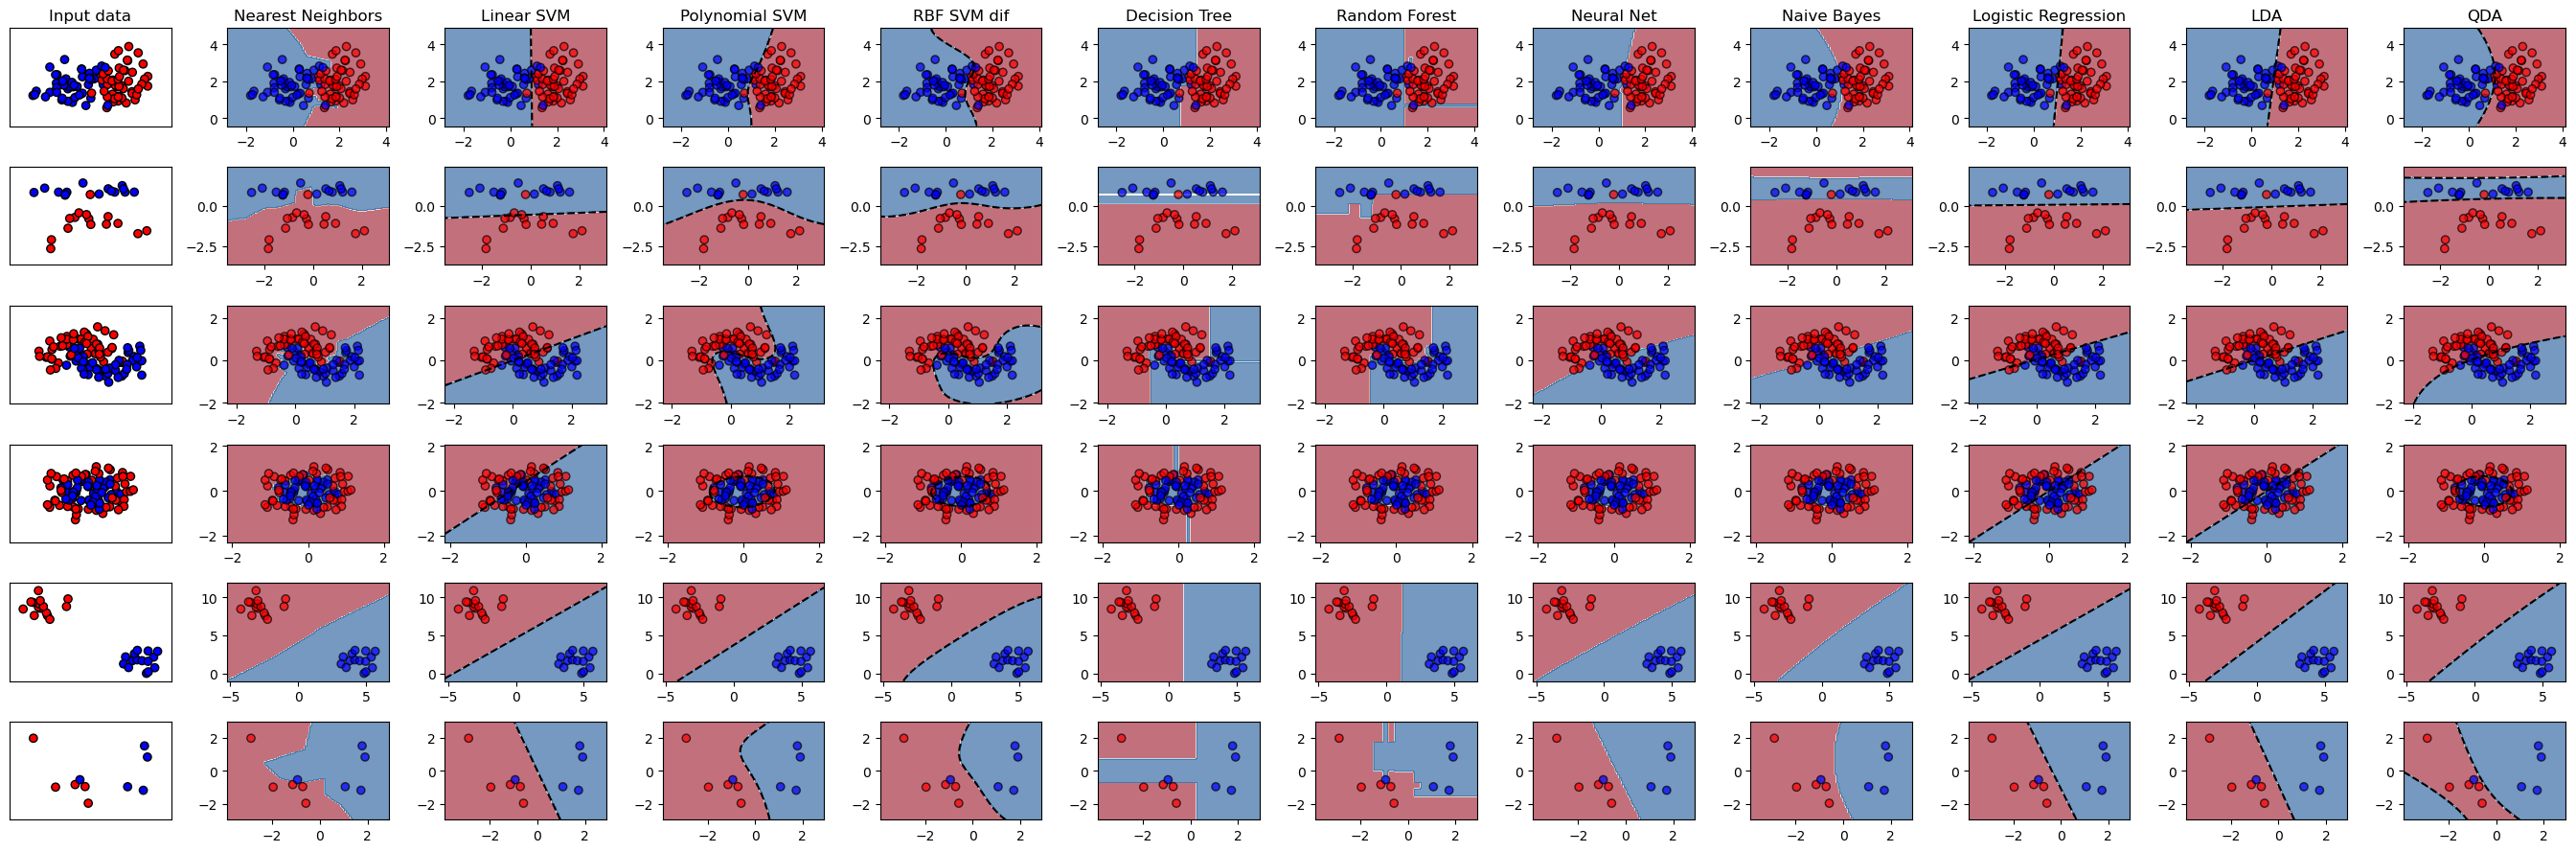

In [6]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=30, features=2, informative=2, random_state=42),
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    generate_blobs_data(samples=30, centers=2, features=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42)
]

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM dif",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes",
    "Logistic Regression",
    "LDA",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(n_neighbors=1),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(kernel="poly", coef0=1, random_state=42),
    SVC(kernel="rbf", random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=42),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
]

default_plotter(datasets, names, classifiers)

# DETAILED COMPARISONS

# NEAREST NEIGHBOURS

In kNN the decision boundary is the dividing line or surface that separates the feature space into regions classified as one class versus another based on the proximity of a query point to the training points. The boundary can be highly non-linear and jagged, especially for low values of k, because each region is determined by the immediate nearest training points. Every data point essentially influences the shape of the boundary.

For 1-NN **(k=1)**, the decision boundary is very sensitive to noise and may overfit the training data. The decision boundary for 1-NN forms a Voronoi diagram, where the feature space is divided into regions based on the closest training point. The edges of these regions represent the decision boundaries.

As **k increases**, the boundary becomes smoother because the classifier takes a majority vote, and it becomes less sensitive to individual noisy points.

The shape of regions can be also influenced by the choice of **distance metric**.

It can handle also not linearly separable data points and more complex shapes as it follows the borders of the regions according to the class distributions in space.


In [7]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_grid_data(grid_size=4, random_state=5),
    generate_grid_data(grid_size=4, random_state=5)
]


names = [
    "Nearest Neighbors K=1 - euclidean",
    "Nearest Neighbors K=1 - manhattan",
    "Nearest Neighbors K=1 - cosine",
    "Nearest Neighbors K=3",
    "Nearest Neighbors K=5"
]

classifiers = [
    KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    KNeighborsClassifier(n_neighbors=1, metric='manhattan'),
    KNeighborsClassifier(n_neighbors=1, metric='cosine'),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=5),
]

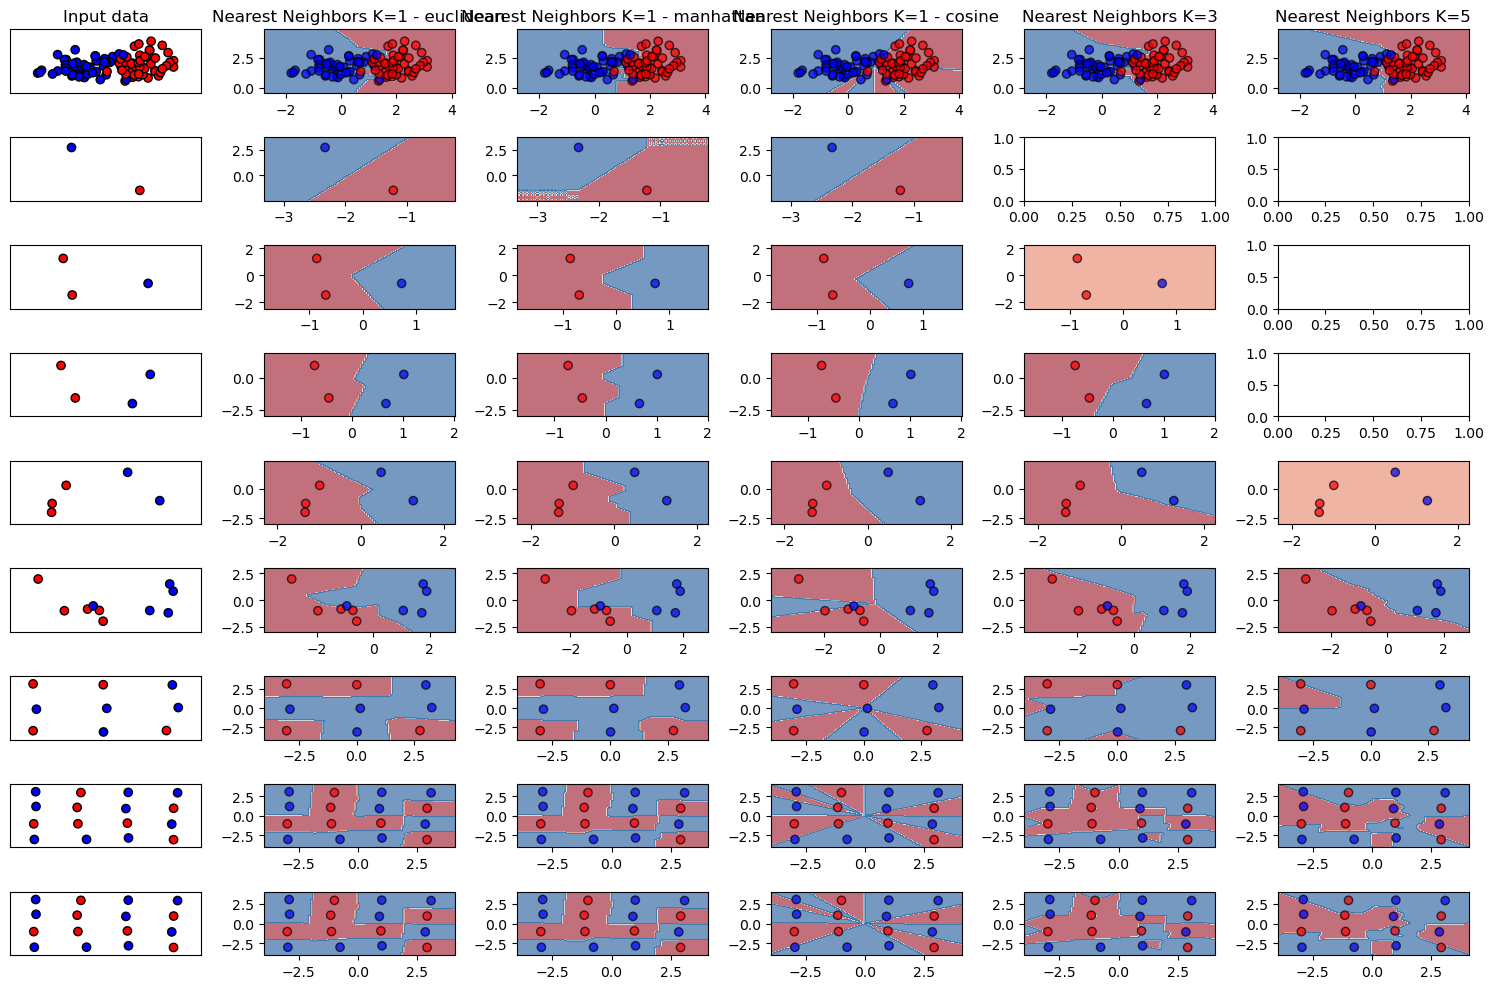

In [8]:
default_plotter(datasets, names, classifiers, plot_dims=(15,10))
# NOTE: We need at least K points to compute KNN

# DECISION TREE

The decision boundary for a decision tree classifier represents the regions in the feature space where the model assigns the same class label.

A decision tree splits the feature space into regions using axis-aligned splits (e.g., "feature >5" or "feature  ≤3" or based on a category 0/1).
The resulting decision boundary is a collection of rectangles (in 2D) or hyper-rectangles (in higher dimensions) - intersections of hyperplanes.

In 2D where the decision boundary is a combination of axis-aligned segments or rectangles, each rectangle corresponds to a leaf node of the tree, and all points within it are assigned the same label.

**Shallow Tree:** Fewer splits -> Large rectangular regions.

**Deep Tree:** More splits -> Smaller, finely divided regions -> Captures finer details of the data distribution but can overfit.


In [9]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_grid_data(grid_size=4, random_state=5),
    generate_grid_data(grid_size=4, random_state=5)
]


names = [
    "Decision Tree depth=1",
    "Decision Tree depth=2",
    "Decision Tree depth=3",
    "Decision Tree depth=4",
    "Decision Tree depth=5",
]


classifiers = [
    DecisionTreeClassifier(max_depth=1, random_state=42),
    DecisionTreeClassifier(max_depth=2, random_state=42),
    DecisionTreeClassifier(max_depth=3, random_state=42),
    DecisionTreeClassifier(max_depth=4, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42)
]


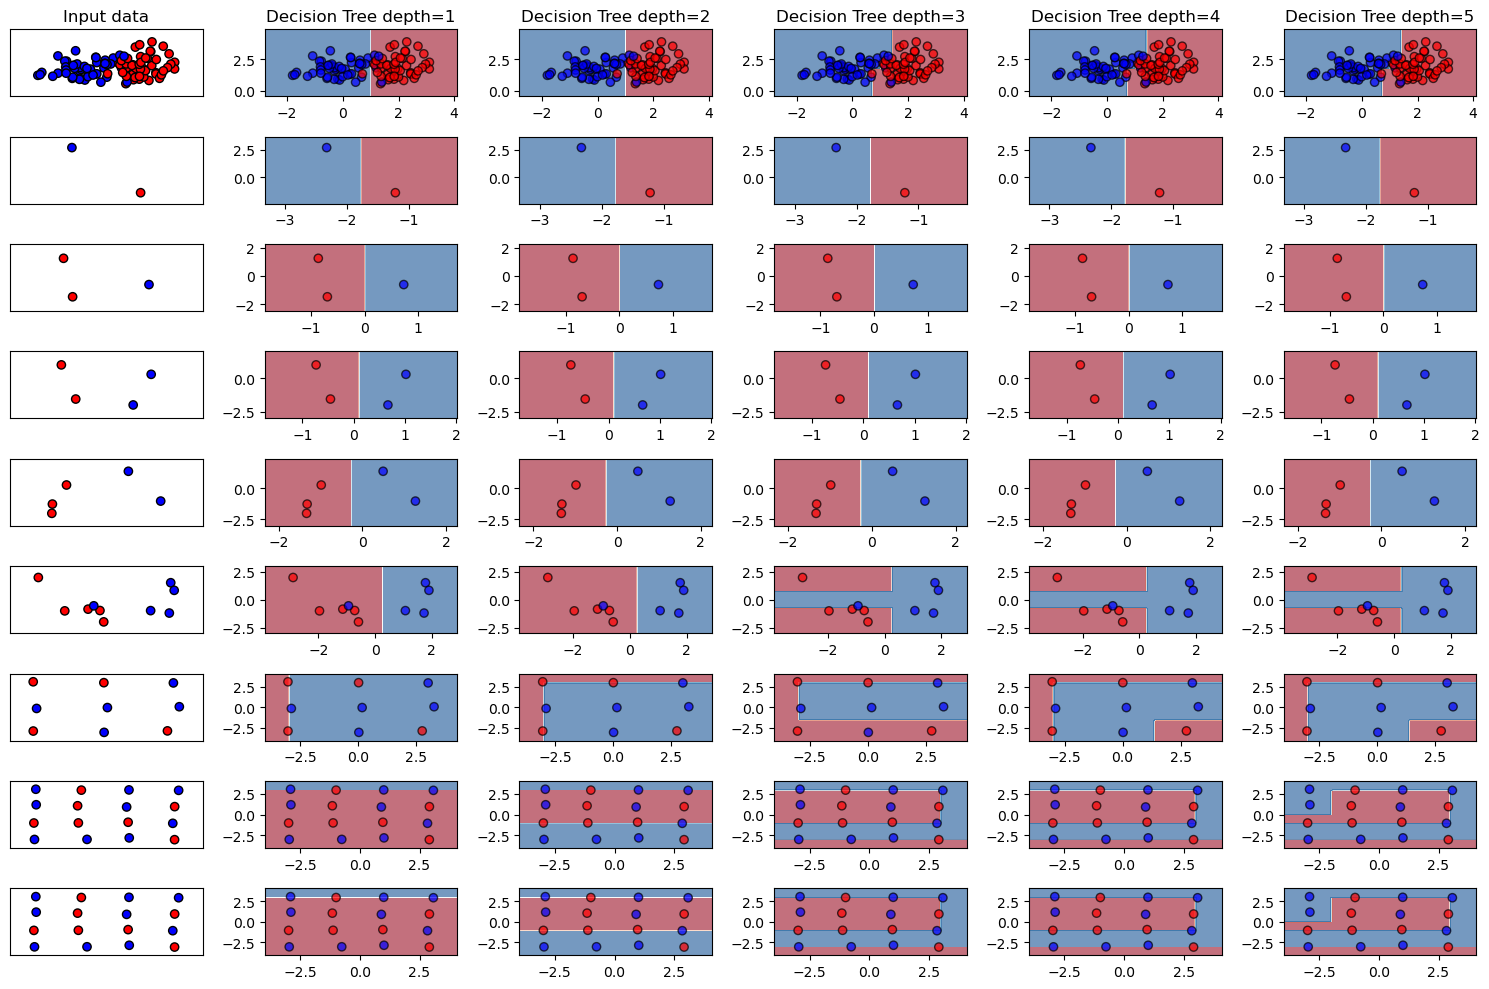

In [10]:
default_plotter(datasets, names, classifiers, plot_dims=(15,10))

# RANDOM FOREST

Each tree generates its own decision boundary, which as we said is typically axis-aligned and piecewise-rectangular. The boundary is more detailed in regions where the training data is dense and less so in sparse regions. This reflects how trees adapt to local patterns.

**More trees** Smoother and more stable boundary, as more trees decrease the influence of outliers and noise.

**Fewer trees:** Slightly noisier, jagged boundaries resembling individual tree splits.

**Shallow trees:** Coarser boundaries, unable to capture small patterns.

**Deep trees:** Finer boundaries, and overfitting risk for individual trees is mitigated by averaging.



In [11]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_grid_data(grid_size=4, random_state=5),
    generate_grid_data(grid_size=4, random_state=5)
]


names = [
    "Random Forest N=1",
    "Random Forest N=2",
    "Random Forest N=5",
    "Random Forest N=10",
    "Random Forest N=50",
]

classifiers = [
    RandomForestClassifier(max_depth=5, n_estimators=1, max_features=1, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=2, max_features=1, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=5, max_features=1, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=50, max_features=1, random_state=42)
    
]

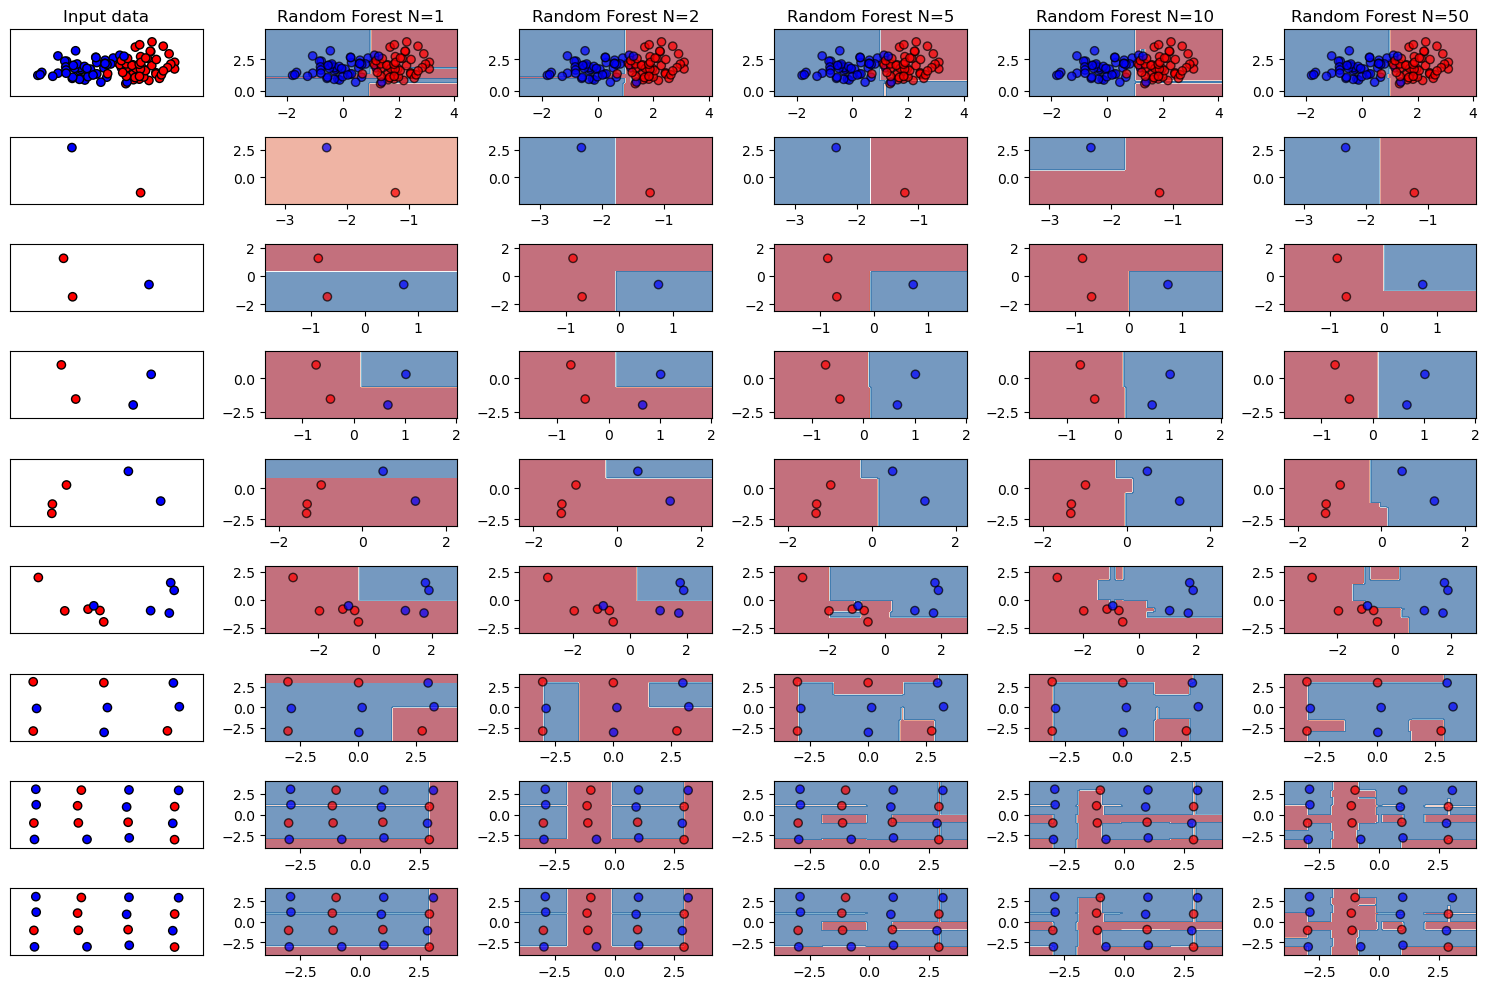

In [12]:
default_plotter(datasets, names, classifiers, plot_dims=(15,10))

# NAIVE BAYES

The decision boundary separates regions where one class has a higher probability than the others.
Mathematically, it’s where P(y1∣X)=P(y2∣X), meaning the probabilities of two classes are equal.

Boundaries, when assuming a gaussian distribtion, are often linear or moderately curved, which reflects the simplicity of the model.
<!-- The type of feature distributions we assume (Gaussian, multinomial, etc.) can directly influence the boundary. -->
If one class has a much higher prior probability P(y), the decision boundary skews in favor of that class.


In [13]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_grid_data(grid_size=4, random_state=5),
    generate_grid_data(grid_size=4, random_state=5)
]


names = [
    "Gaussian Naive Bayes",
]

classifiers = [
    GaussianNB(),

    
]

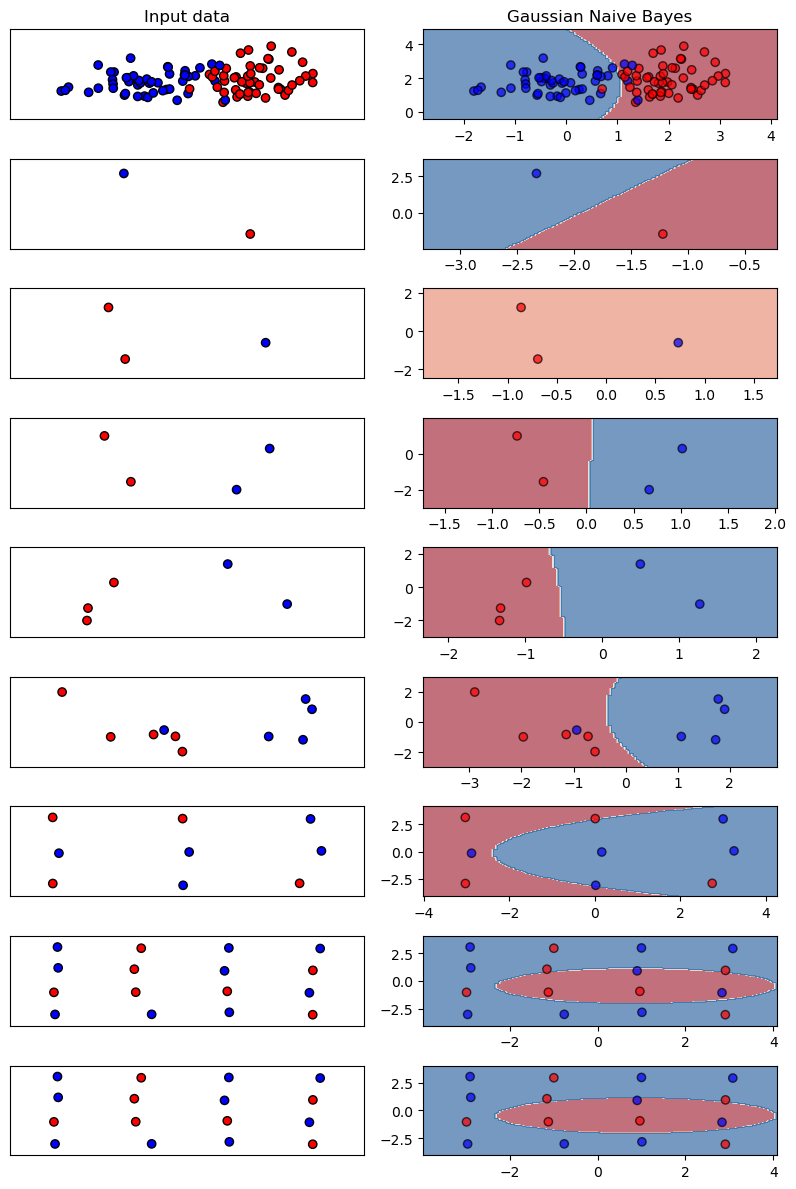

In [14]:
default_plotter(datasets, names, classifiers, plot_dims=(8, 12))

# LOGISTIC REGRESSION
The region where the predicted probability of one class equals that of another (typically at 50%).
Logistic regression produces a linear decision boundary because it is based on a linear combination of input features passed through a sigmoid function.
Using logistic regression to classify two classes in a 2D plane produces the decision boundary as a straight line. In higher dimensions, it becomes a hyperplane. Due to the linear nature of DB it cannot effectively separate non-linear patterns such as moons or blobs.

<!-- Regularization can shrink the coefficients leading to less steepness until we reach the horizontal line -> which gives us the average for the dependent variable. -->
With too much regularization, the model may oversimplify, leading to underfitting and a less effective boundary.

In [15]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_moons_data(samples=30, random_state=42)
]


names = [
    "Logistic Regression",
    "LogReg no reg.",
    "LogReg L1 reg.",
    "LogReg L2 reg.",
    "LogReg ElasticNet reg."

]

classifiers = [
    LogisticRegression(),
    LogisticRegression(penalty=None),
    LogisticRegression(penalty="l1", solver="liblinear"),
    LogisticRegression(penalty="l2"),
    LogisticRegression(penalty="elasticnet", l1_ratio=0.5, solver="saga")
]

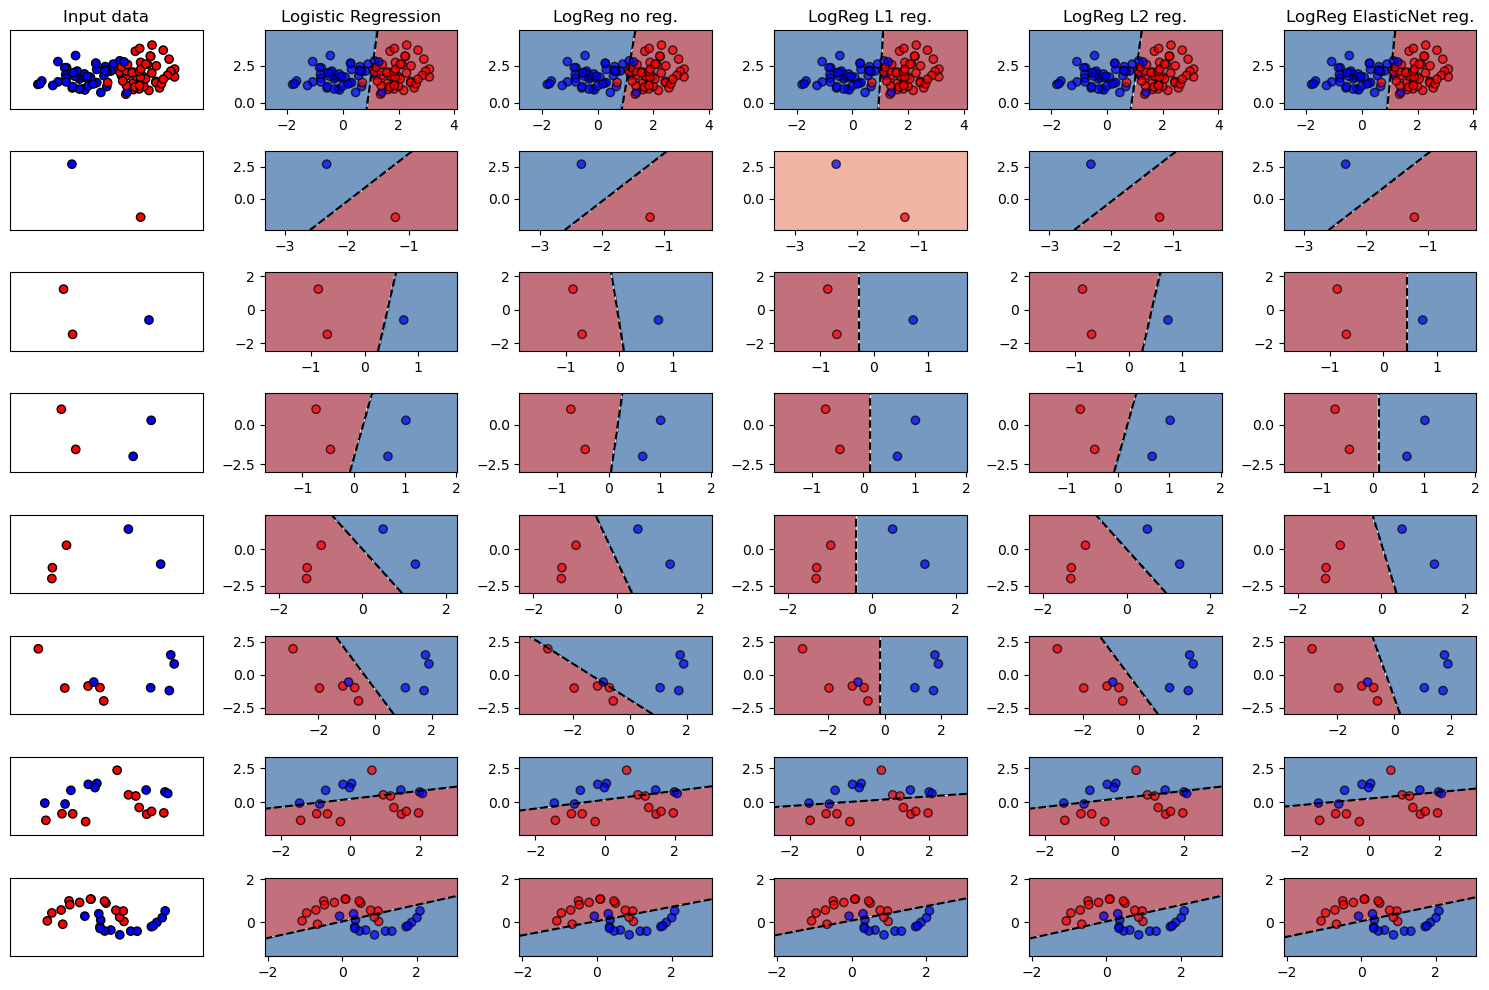

In [16]:
default_plotter(datasets, names, classifiers, plot_dims=(15, 10))

# Linear discriminant analysis

It tries to find the linear combination of features that best separates the classes. This results in a linear decision boundary.

The decision boundary is a straight line (in 2D) or a hyperplane (in higher dims) that separates the two classes.
The decision boundary is perpendicular to the line connecting the class means and located based on the prior probabilities and covariances. The method tries to separate the two means as much as possible.

Since it produces a linear decision boundary it has issues separating non-linear patterns such as overlapping distributions.

In [17]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_moons_data(samples=30, random_state=42)
]


names = [
    "LDA",
]

classifiers = [
    LinearDiscriminantAnalysis(),
]

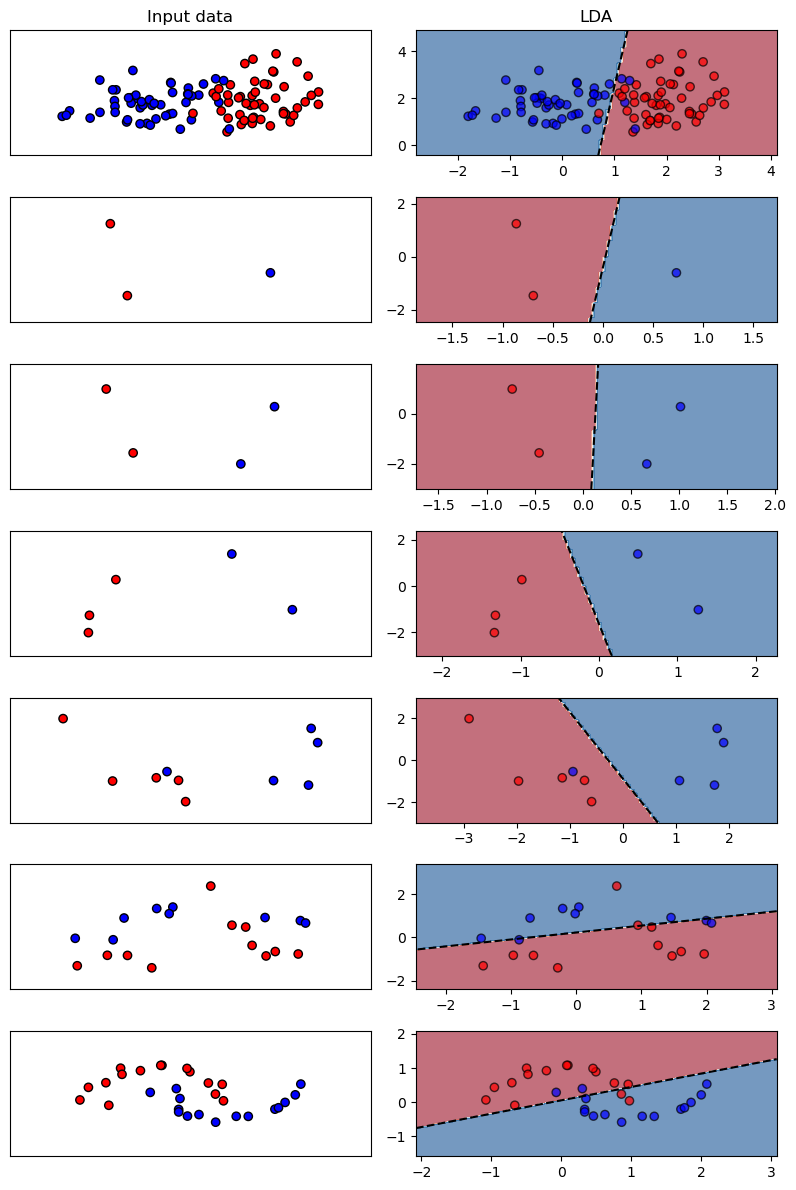

In [18]:
default_plotter(datasets, names, classifiers, plot_dims=(8, 12))

# Quadratic discriminant analysis

QDA allows each class to have its own covariance matrix instead of assuming a shared covariance matrix for all classes.
This results in quadratic decision boundaries rather than linear ones. 
QDA is more flexible than LDA and can model some non-linear relationships between features and classes, so it can also handle a more complex datasets.

In [19]:
datasets = [
    linearly_separable,
    # generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    # generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_moons_data(samples=30, random_state=42),
    generate_circles_data(samples=40, noise=0.1, factor=0.6, random_state=None)
]


names = [
    "QDA",
]

classifiers = [
    QuadraticDiscriminantAnalysis(),
]

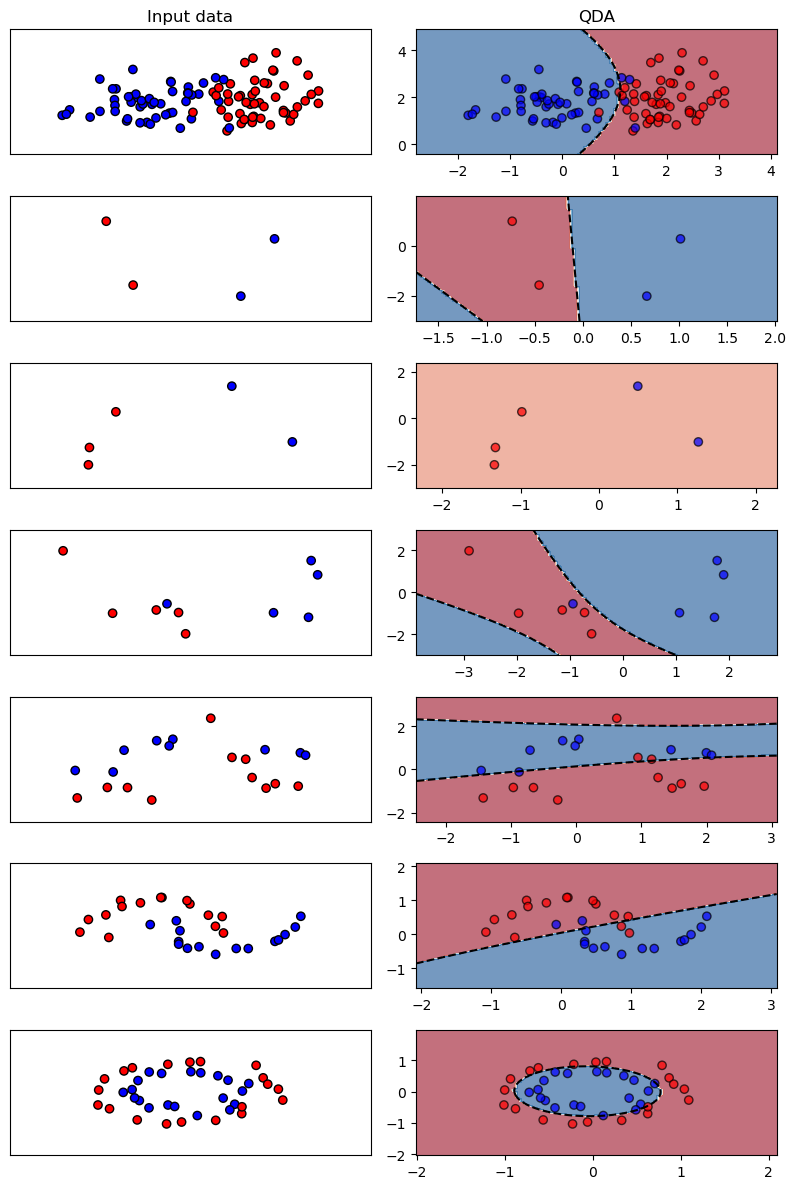

In [20]:
default_plotter(datasets, names, classifiers, plot_dims=(8,12))

# MLP

The hidden layer's non-linearity allows the MLP to model non-linear decision boundaries. 



For a single neuron it can specify decision boundary is linear because the single neuron applies a weighted sum of the inputs so it separates the space in two subspaces. By introducing a hidden layer we are introducing an arbitrary number of these space divisions which we can combine in the output neuron.
So hidden neurons collectively partition the feature space into regions and combine them to form the curved boundary.

For linearly separable data (e.g., points separable by a straight line), the decision boundary of an MLP can resemble that of logistic regression: a straight line or hyperplane. If the hidden layer has enough neurons, it can still introduce some slight curvature, but the problem doesn’t require it.

With enough neurons in the hidden layer, an MLP can approximate any decision boundary (this is a result of the Universal Approximation Theorem). However, the number of neurons and training data must be sufficient to represent the complexity of the data.

In [21]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_moons_data(samples=30, random_state=42),
    generate_circles_data(samples=40, noise=0.1, factor=0.6, random_state=None)
]


names = [
    "MLP 1 hidden neuron",
    "MLP 2 hidden neurons",
    "MLP 5 hidden neurons",
    "MLP 10 hidden neurons",
    "MLP 100 hidden neurons",
    "MLP 400 hidden neurons", 
    "MLP 1000 hidden neurons"
]

classifiers = [
    MLPClassifier(hidden_layer_sizes=(1,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(2,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(1000,), activation='relu', max_iter=1000, random_state=42)

]

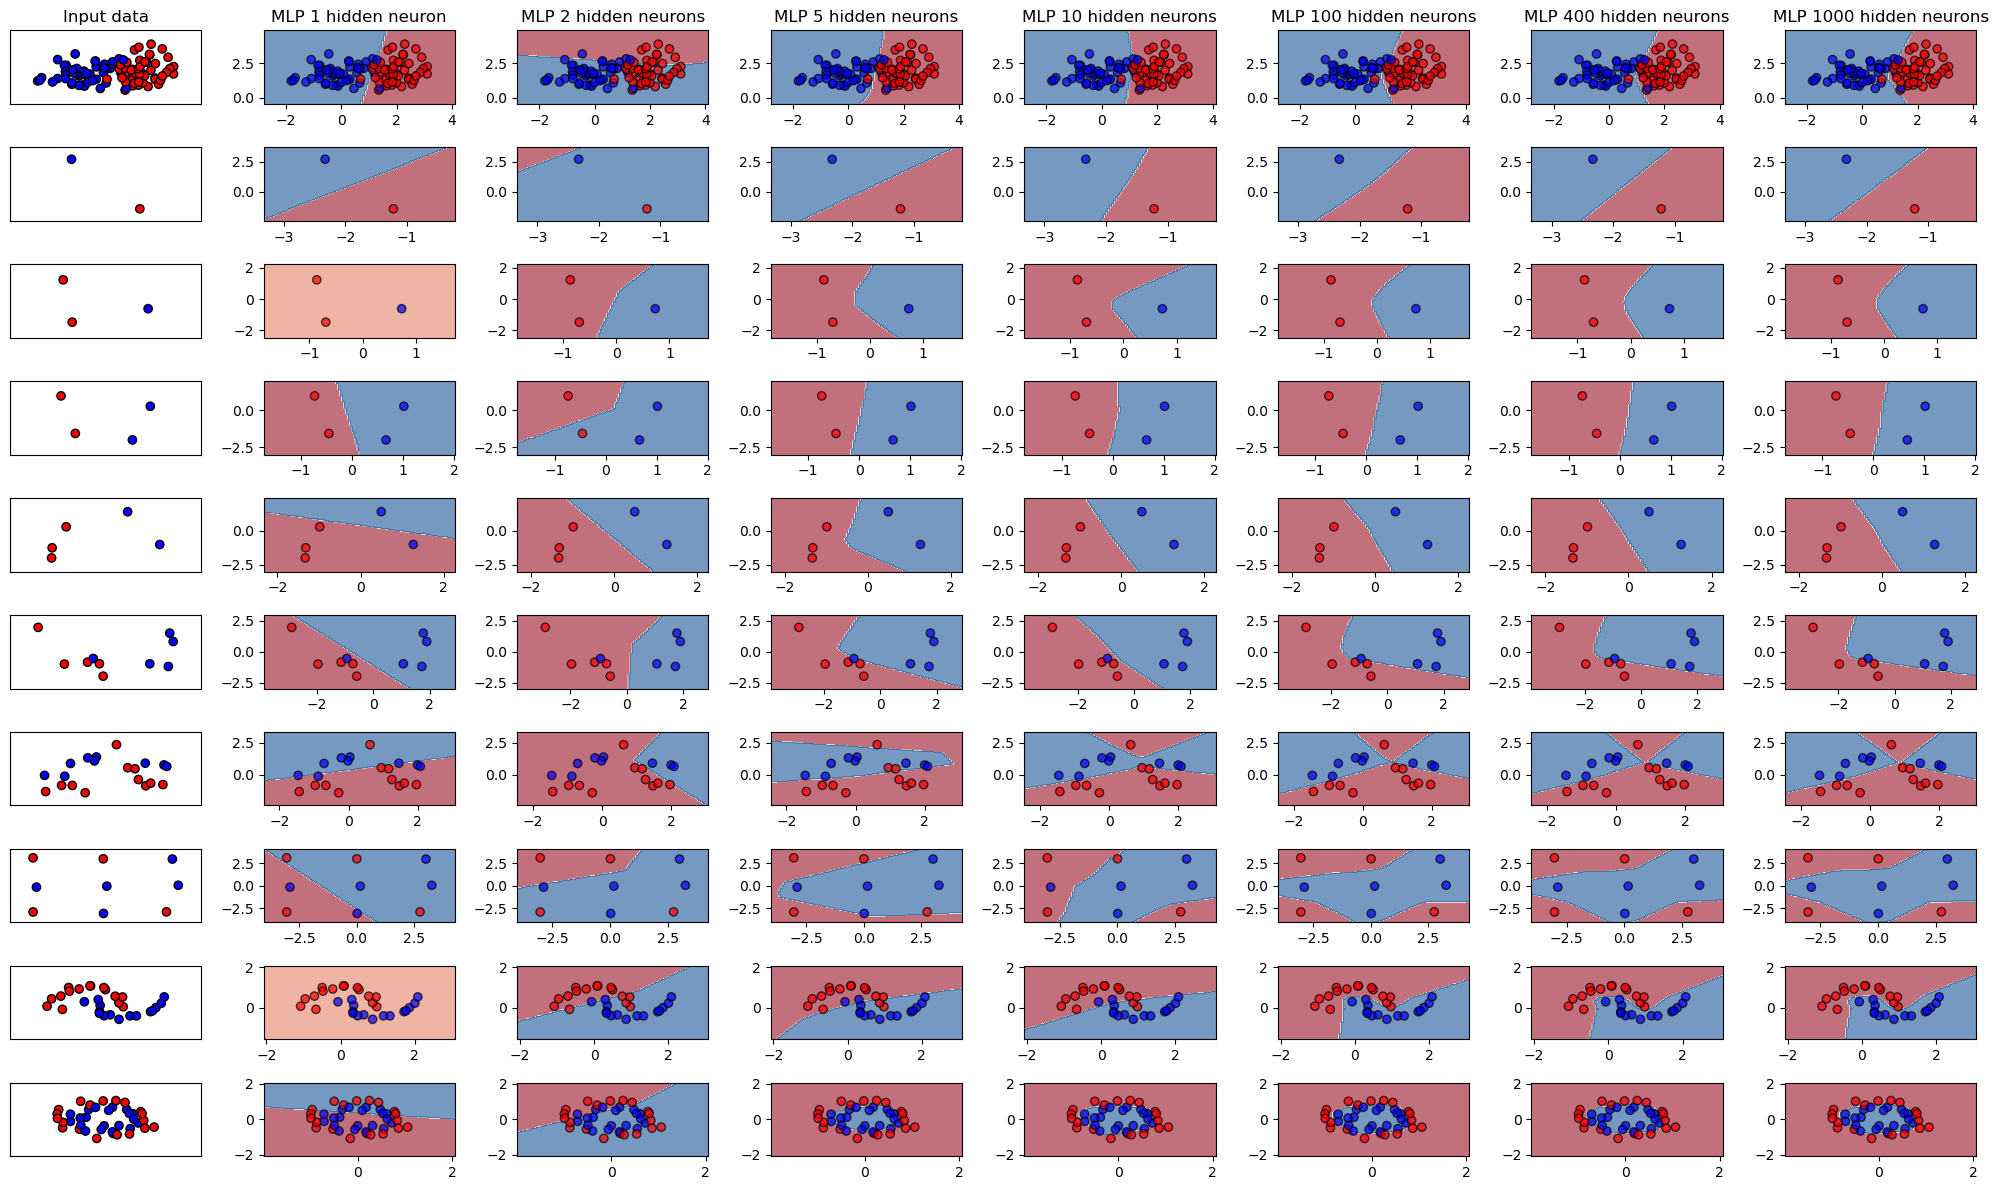

In [22]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))

### How hyperparameters affect the decision boundary

#### Number of neurons in the hidden layer:

**Few neurons:** The model may underfit and produce overly simple decision boundaries (e.g., straight or slightly curved lines).

**More neurons:** Allows the model to capture more complex decision boundaries.

For example, with moons data, adding neurons enables the network to curve and adapt to the crescent shapes.

**Too many neurons:** Increases the risk of overfitting, where the decision boundary becomes unnecessarily complex and starts fitting noise.



In [23]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_moons_data(samples=30, random_state=42),
    generate_circles_data(samples=40, noise=0.1, factor=0.6, random_state=None)
]


names = [
    "MLP 10 init lr=0.001",
    "MLP 10 init lr=0.01",
    "MLP 10 init lr=1.0",

    "MLP 100 init lr=0.001",
    "MLP 100 init lr=0.01",
    "MLP 100 init lr=1.0",
    
    "MLP 400 init lr=0.001",
    "MLP 400 init lr=0.01",
    "MLP 400 init lr=1.0",
]

classifiers = [
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=0.001),
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=0.01),
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=1.0),

    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=0.001),
    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=0.01),
    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=1.0),
    
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=0.001),
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=0.01),
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42, learning_rate_init=1.0),
]

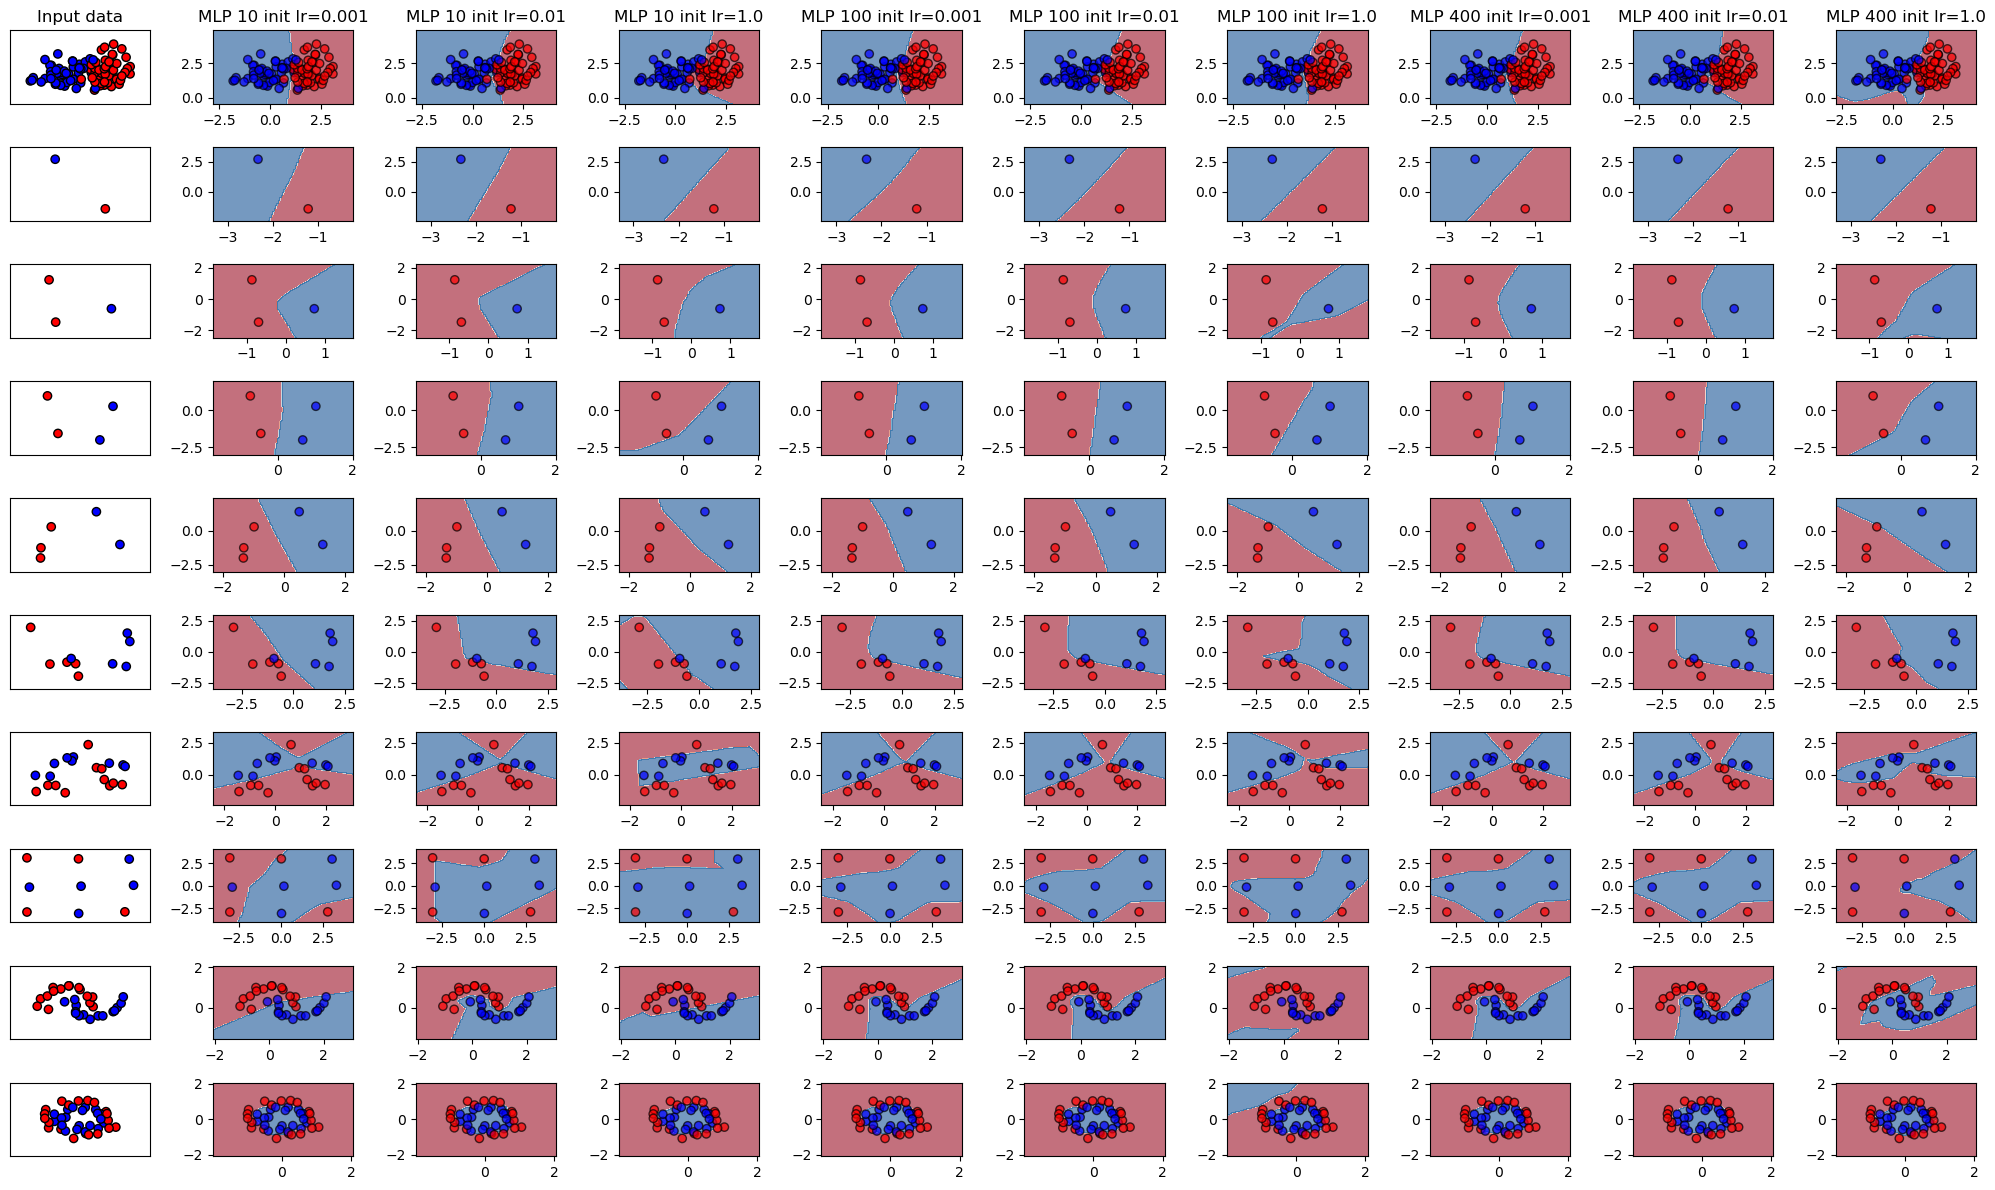

In [24]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))

#### Regularization
Alpha is a parameter for regularization term, aka penalty term, that combats overfitting by constraining the size of the weights. Increasing alpha may fix high variance (a sign of overfitting) by encouraging smaller weights, resulting in a decision boundary plot that appears with lesser curvatures. Similarly, decreasing alpha may fix high bias (a sign of underfitting) by encouraging larger weights, potentially resulting in a more complicated decision boundary.

In [25]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_moons_data(samples=30, random_state=42),
    generate_circles_data(samples=40, noise=0.1, factor=0.6, random_state=None)
]


names = [
    "MLP 10 alpha=0.1",
    "MLP 10 alpha=1.0",
    "MLP 10 alpha=10.0",

    "MLP 100 alpha=0.1",
    "MLP 100 alpha=1.0",
    "MLP 100 alpha=10.0",
    
    "MLP 400 alpha=0.1",
    "MLP 400 alpha=1.0",
    "MLP 400 alpha=10.0",
]

classifiers = [
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42, alpha=0.1),
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42, alpha=1),
    MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=42, alpha=10),

    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, alpha=0.1),
    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, alpha=1),
    MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, alpha=10),
    
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42, alpha=0.1),
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42, alpha=1),
    MLPClassifier(hidden_layer_sizes=(400,), activation='relu', max_iter=1000, random_state=42, alpha=10),

]

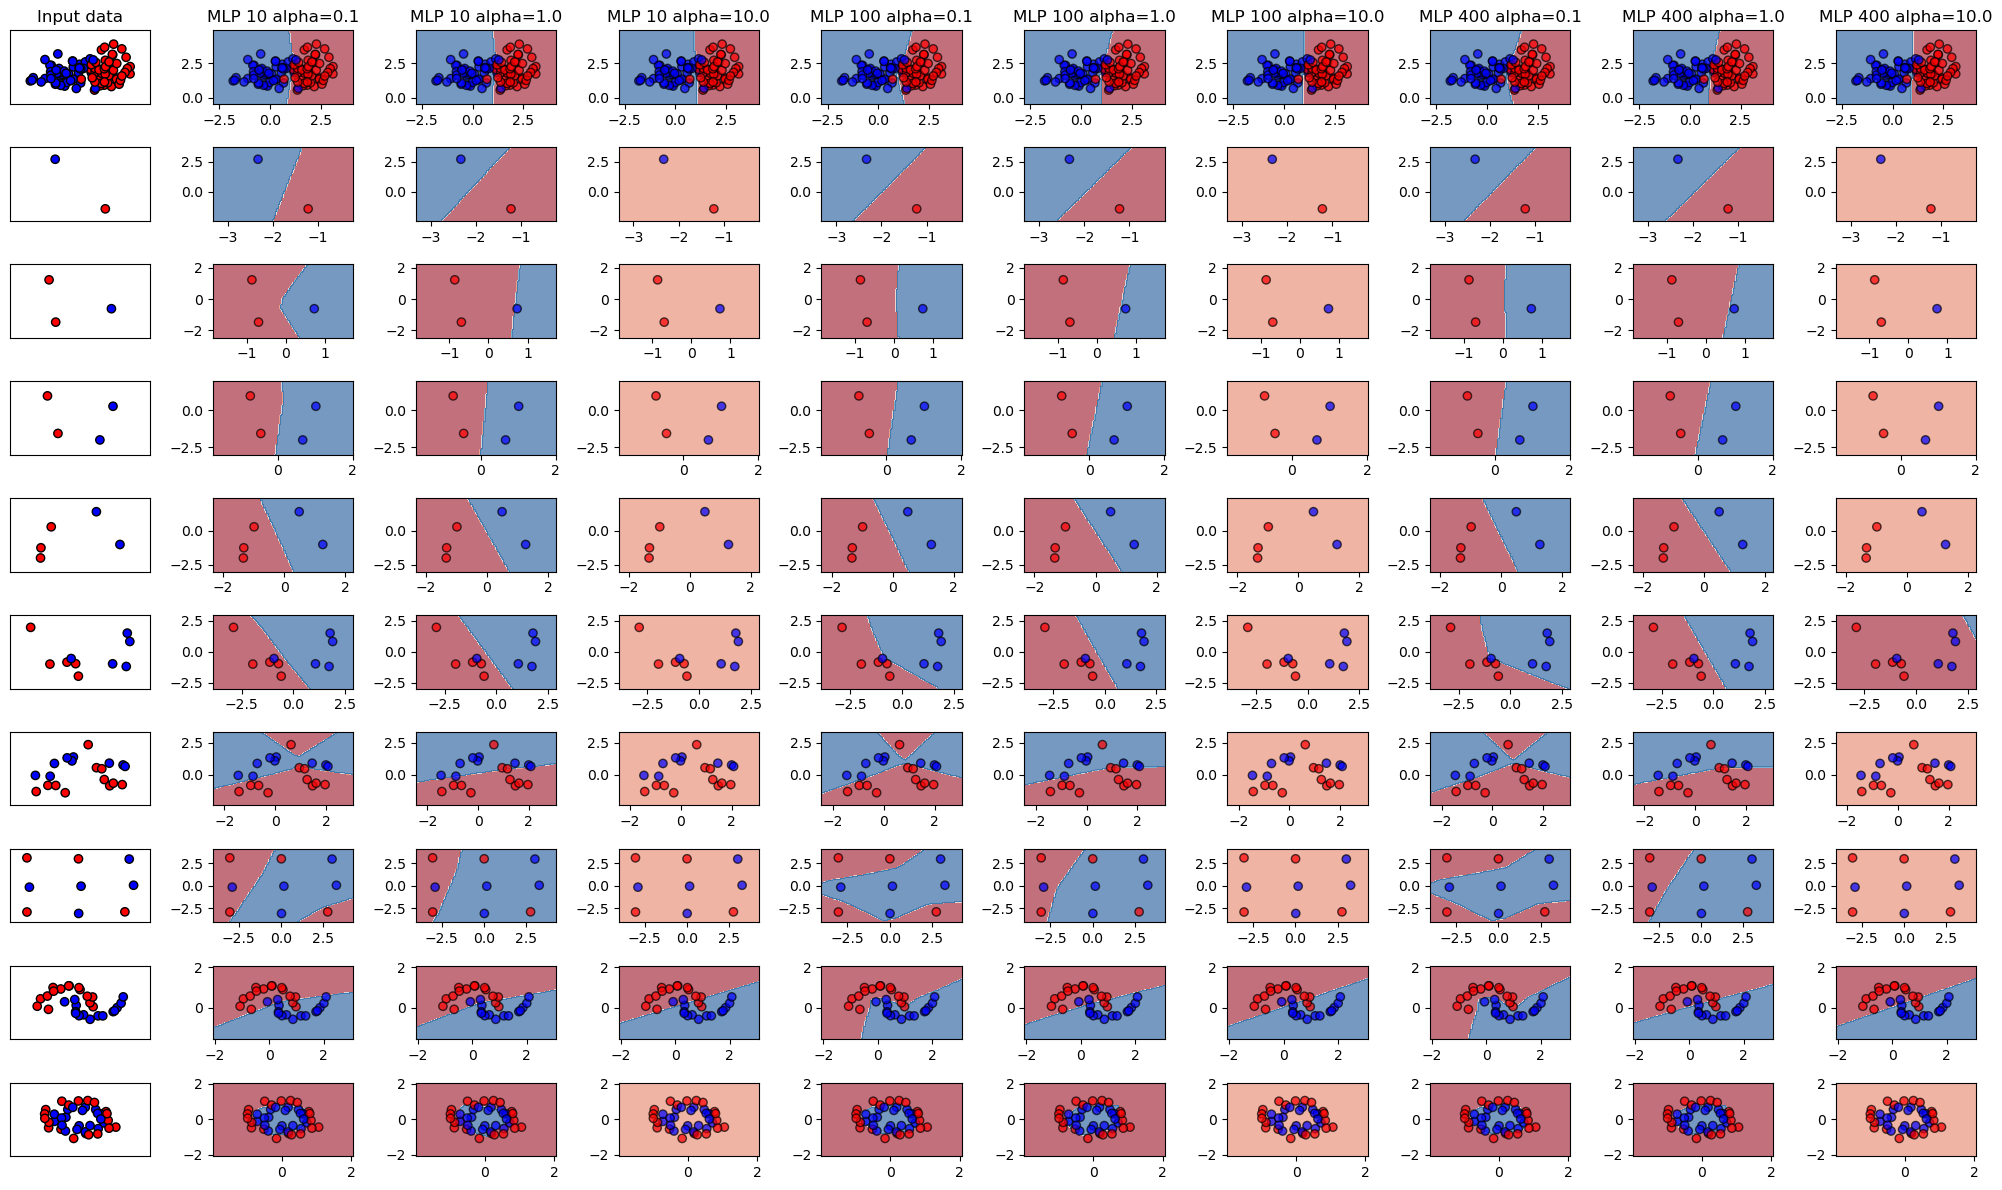

In [26]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))

#### Learning Rate:

A low learning rate might cause the decision boundary to converge too slowly, resulting in suboptimal performance.
A high learning rate might lead to instability, causing the boundary to oscillate without finding a good fit.

#### Number of Training Epochs:

Training for too few epochs can lead to underfitting, with an overly simple boundary.
Too many epochs can lead to overfitting, where the boundary becomes unnecessarily detailed and complex.

### What DB does MLP with more than 1 hidden layer generate?


In [27]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_moons_data(samples=30, random_state=42),
    generate_circles_data(samples=40, noise=0.1, factor=0.6, random_state=None)
]


names = [
    "MLP 10, 10",
    "MLP 10, 10",
    "MLP 10, 10",

    "MLP 100, 100",
    "MLP 100, 100",
    "MLP 100, 100",
    
    "MLP 400, 400",
    "MLP 400, 400",
    "MLP 400, 400",

    "MLP 100, 50, 10",
]

classifiers = [
    MLPClassifier(hidden_layer_sizes=(10,10,), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(10,10, ), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(10,10,), activation='relu', max_iter=1000, random_state=42),

    MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', max_iter=1000, random_state=42),
    
    MLPClassifier(hidden_layer_sizes=(400,400), activation='relu', max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(400,400), activation='relu', max_iter=1000, random_state=42,),
    MLPClassifier(hidden_layer_sizes=(400,400), activation='relu', max_iter=1000, random_state=42),

    MLPClassifier(hidden_layer_sizes=(100,50,10,), activation='relu', max_iter=1000, random_state=42),

]

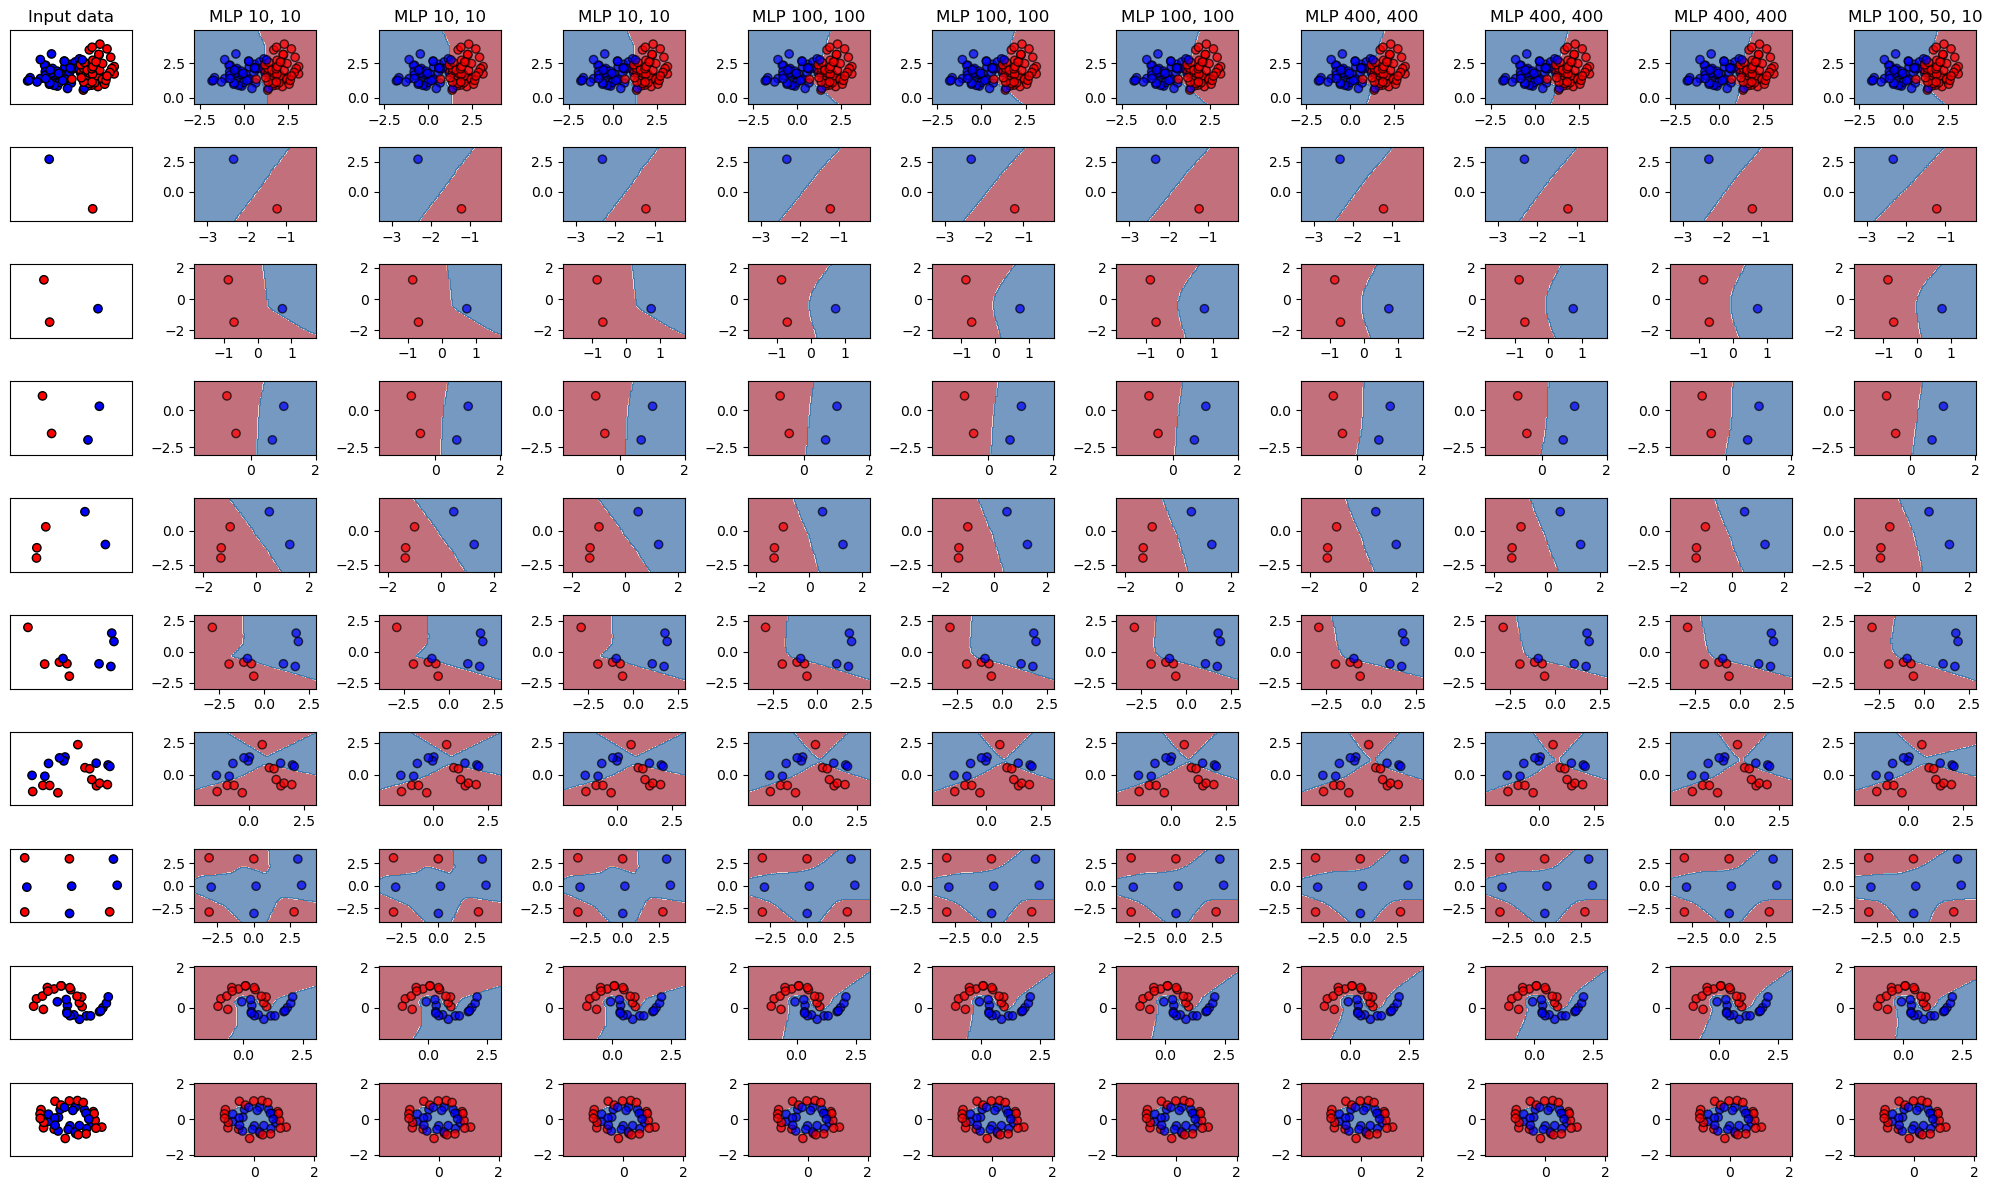

In [28]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))

# SVM

For linearly separable data, the SVM constructs a straight line (in 2D) or a hyperplane (in higher dimensions) as the decision boundary.

When data is not linearly separable, we can use different (than linear) kernels to map the data into a higher-dimensional space where it becomes linearly separable. The decision boundary is then a non-linear curve in the original input space but linear in the feature space.

In the case of a **polynomial kernel**, with the increasing degree of the polynomial, the SVM can fit more detailed/complex (e.g., twisting more) boundaries between classes, but we also risk overfitting to the data.

**Margin Softness (Slack Variable):**
For datasets with overlapping classes, SVM can use slack variables to allow some points to violate the margin.
A softer margin leads to smoother boundaries that tolerate noise, while a harder margin enforces stricter separation.

In [29]:
datasets = [
    linearly_separable,
    generate_classification_data(samples=2, features=2, informative=2, random_state=42),
    generate_classification_data(samples=3, features=2, informative=2, random_state=42),
    generate_classification_data(samples=4, features=2, informative=2, random_state=42),
    generate_classification_data(samples=5, features=2, informative=2, random_state=42),
    generate_classification_data(samples=10, features=2, informative=2, random_state=42),    
    generate_classification_data(samples=20, features=2, informative=2, random_state=42),
    generate_grid_data(grid_size=3, random_state=6),
    generate_moons_data(samples=30, random_state=42),
    generate_circles_data(samples=40, noise=0.1, factor=0.6, random_state=None)
]


names = [
    "SVM-C Linear K",
    "SVM-C Poly K, d=2",
    "SVM-C Poly K, d=3",
    "SVM-C RBF K"
]
 # CONSIDER probability=True,
classifiers = [
    SVC(kernel="linear", random_state=42),
    SVC(kernel="poly", coef0=1, degree=2, random_state=42),
    SVC(kernel="poly", coef0=1, degree=3, random_state=42),
    SVC(kernel="rbf", random_state=42),

]

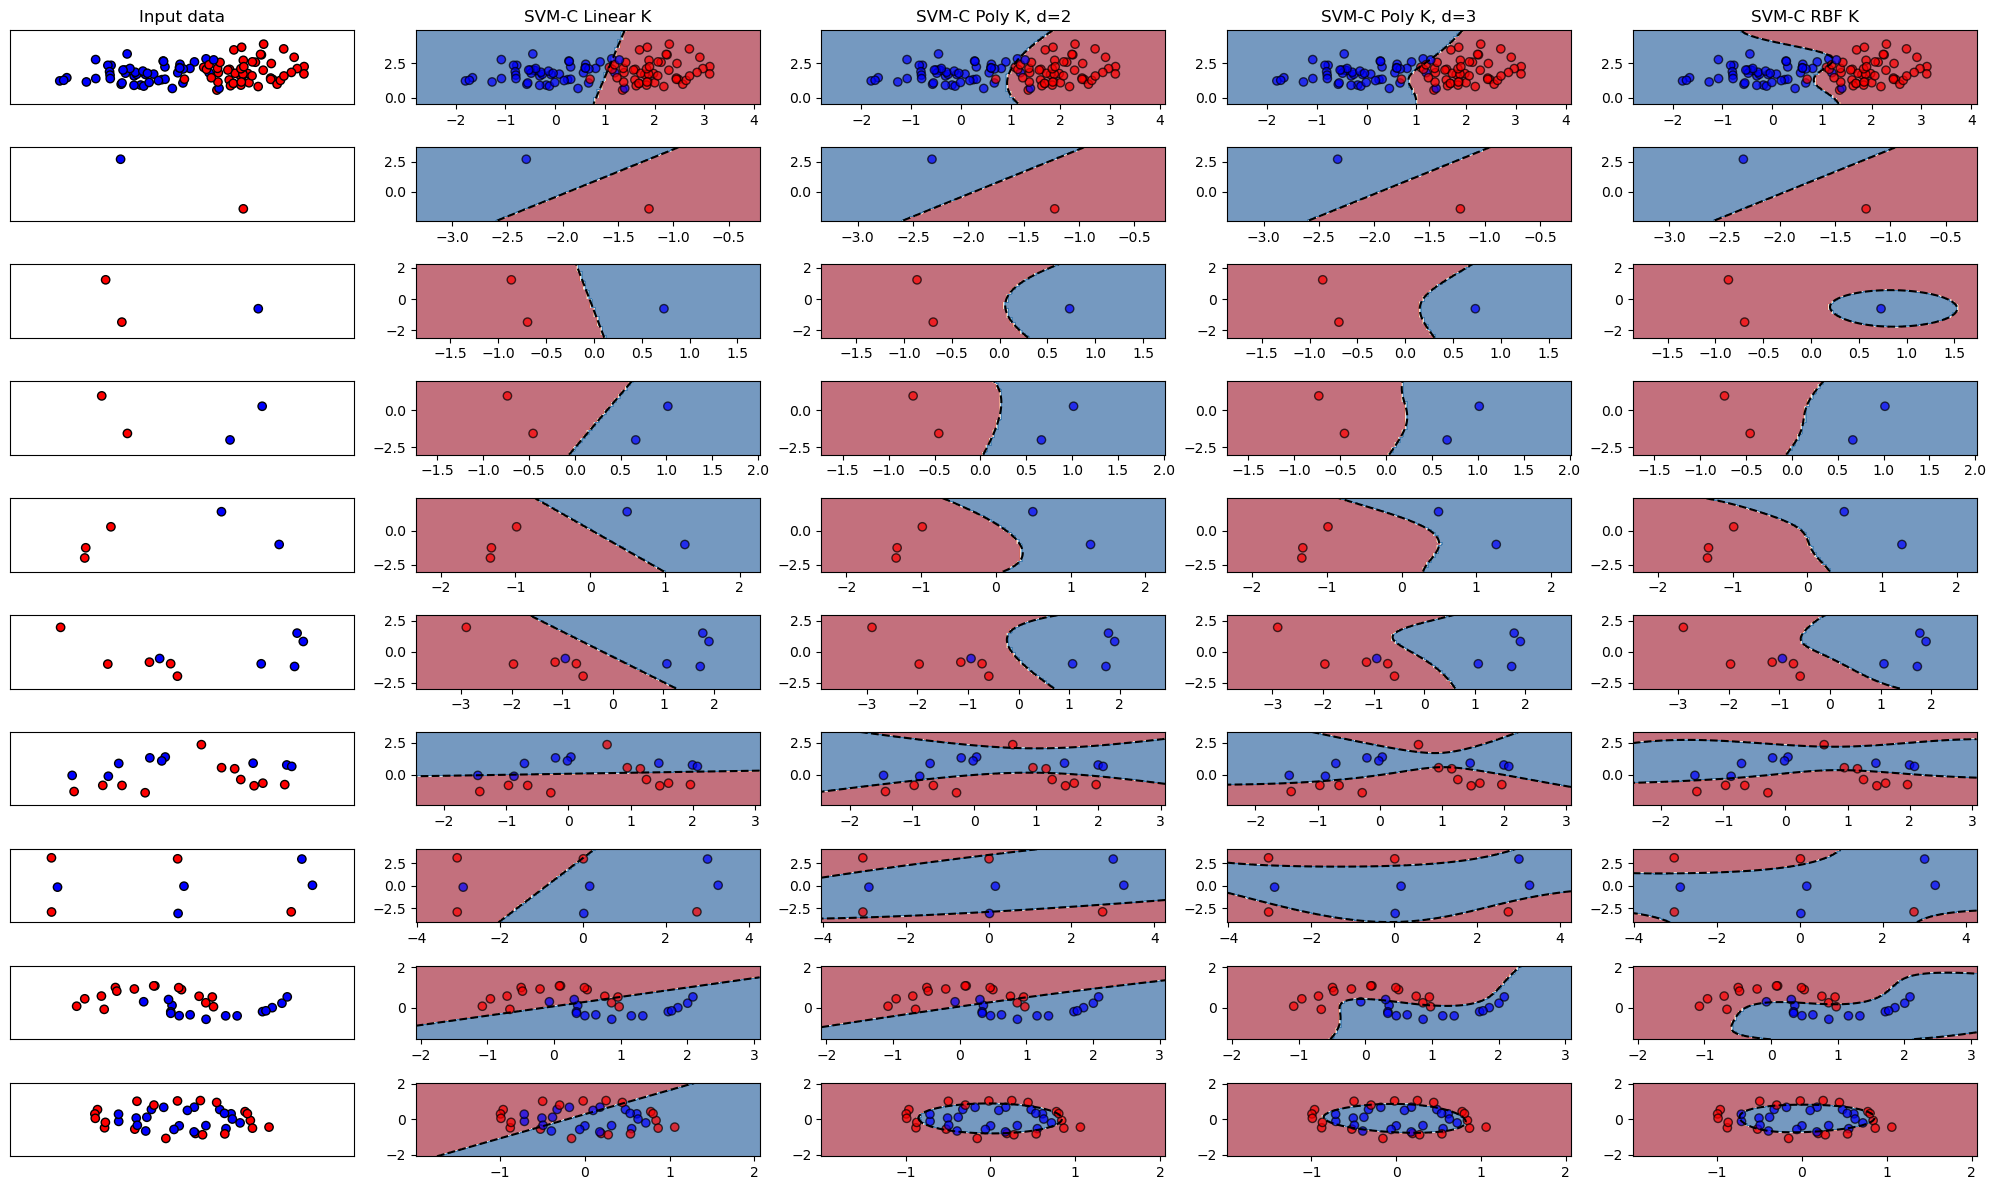

In [30]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))

#### Regularization Parameter (C):
C controls the trade-off between maximizing the margin and minimizing misclassification:

**Small C:** Increases margin size by allowing some misclassifications. This leads to a simpler, smoother decision boundary that generalizes better.

**Large C:** Reduces the margin to classify all training points correctly. This can result in a complex boundary that overfits the training data.


In [31]:
names = [
    "SVM-C Linear K, C=0.025",
    "SVM-C Linear K, C=0.7",
    "SVM-C Linear K, C=5",

    "SVM-C Poly K, d=3, C=0.025",
    "SVM-C Poly K, d=3, C=0.7",
    "SVM-C Poly K, d=3, C=5",

    "SVM-C RBF K, C=0.025",
    "SVM-C RBF K, C=0.7",
    "SVM-C RBF K, C=5"
]

classifiers = [
    SVC(kernel="linear", random_state=42, C=0.025),
    SVC(kernel="linear", random_state=42, C=0.7),
    SVC(kernel="linear", random_state=42, C=5),
    

    SVC(kernel="poly", coef0=1, degree=3, random_state=42, C=0.025),
    SVC(kernel="poly", coef0=1, degree=3, random_state=42, C=0.7),
    SVC(kernel="poly", coef0=1, degree=3, random_state=42, C=5),
    
    SVC(kernel="rbf", random_state=42, C=0.025),
    SVC(kernel="rbf", random_state=42, C=0.7),
    SVC(kernel="rbf", random_state=42, C=5),
]

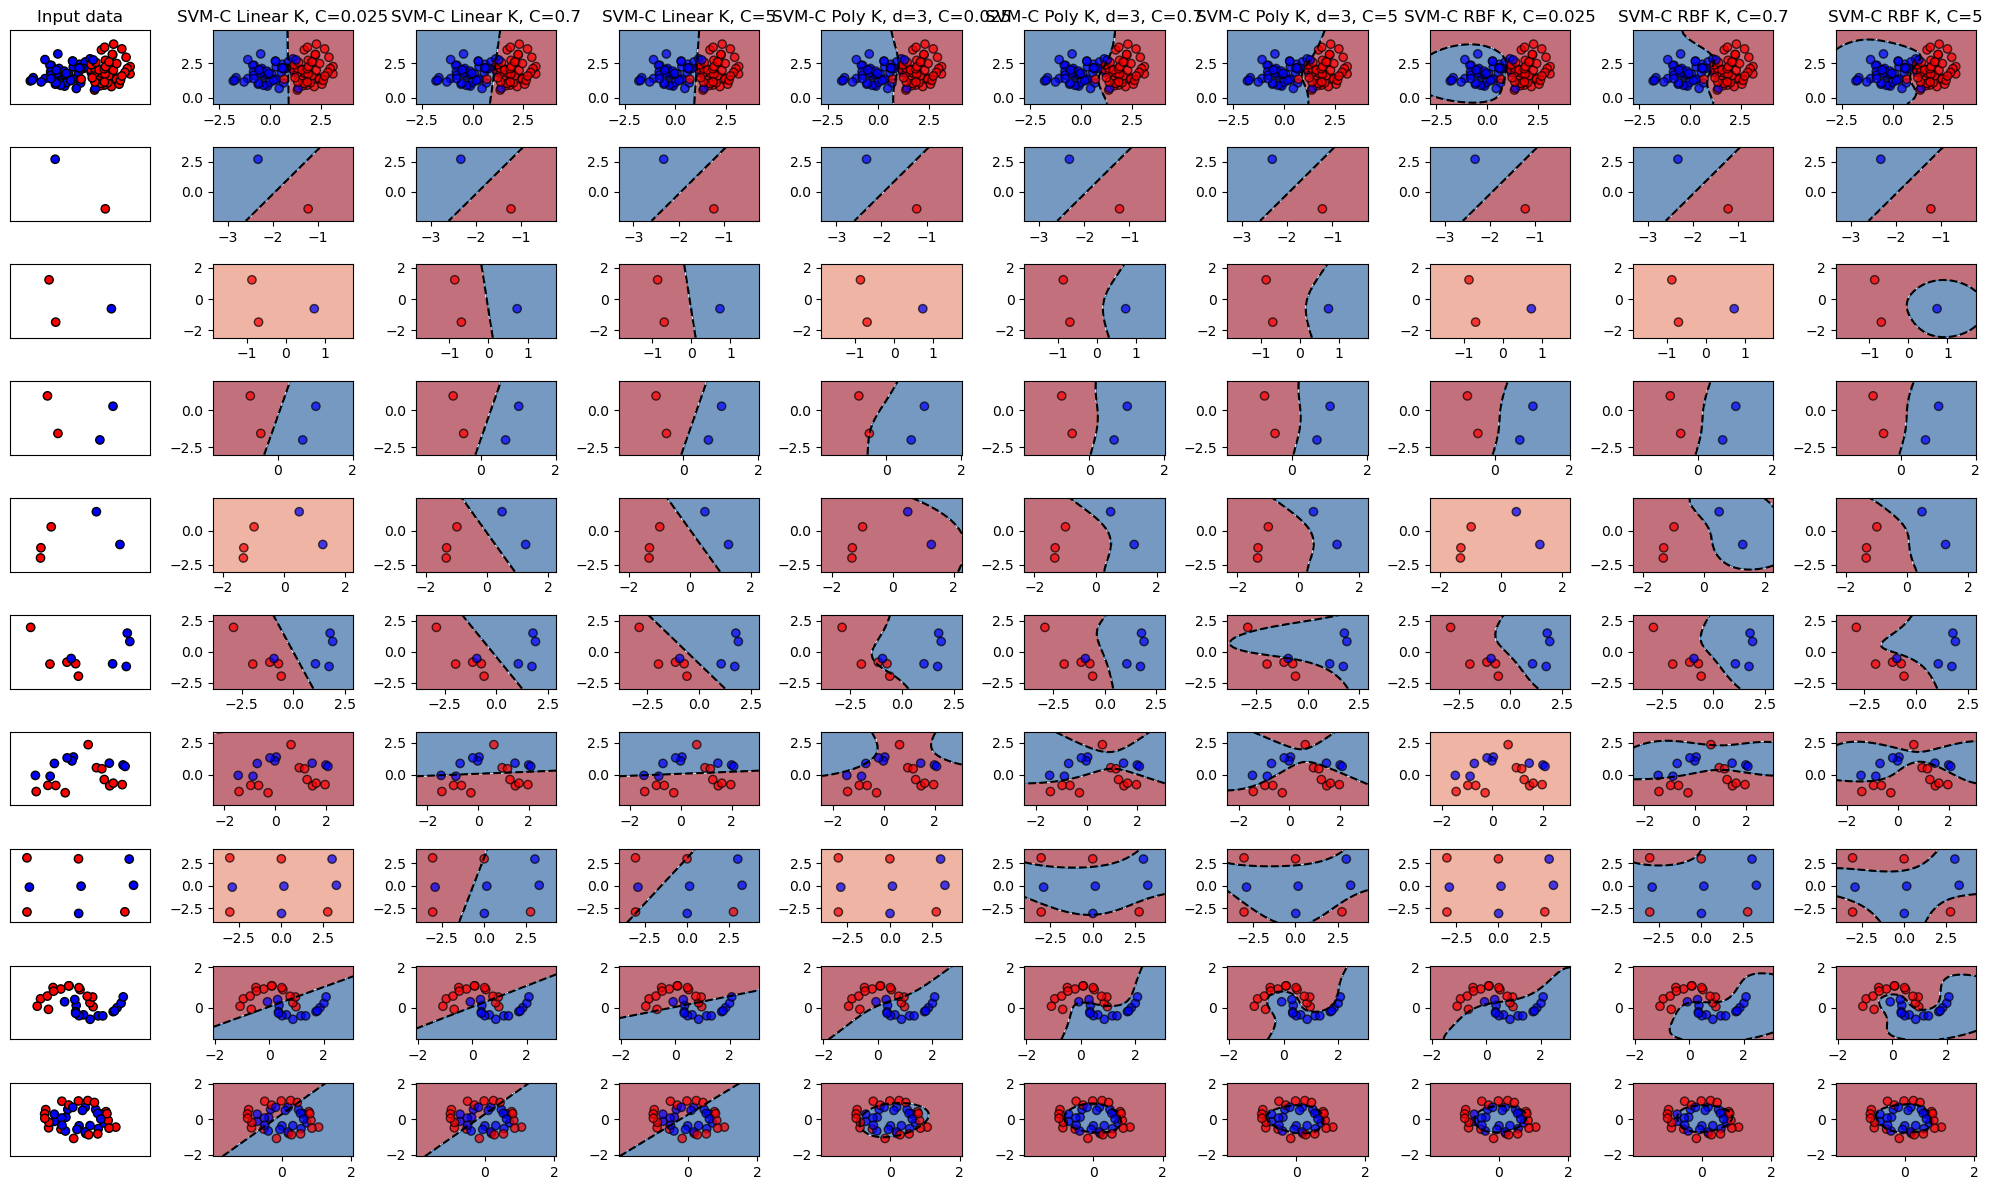

In [32]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))



#### Gamma (for RBF Kernel):
Gamma controls the influence of individual data points on the decision boundary:

**Low Gamma:** Each data point has a far-reaching influence, leading to smoother, more generalized decision boundaries.

**High Gamma:** Each data point has a limited influence, resulting in a highly flexible decision boundary that can overfit the data.



In [33]:
names = [
    "SVM-C RBF gamma=0.01",
    "SVM-C RBF gamma=0.3",
    "SVM-C RBF gamma=1",
    "SVM-C RBF gamma=3",
    "SVM-C RBF gamma=10"
]
 # CONSIDER probability=True,
classifiers = [
    SVC(kernel="rbf", gamma=0.01, random_state=42),
    SVC(kernel="rbf", gamma=0.3, random_state=42),
    SVC(kernel="rbf", gamma=1, random_state=42),
    SVC(kernel="rbf", gamma=3, random_state=42),
    SVC(kernel="rbf", gamma=10, random_state=42)
]

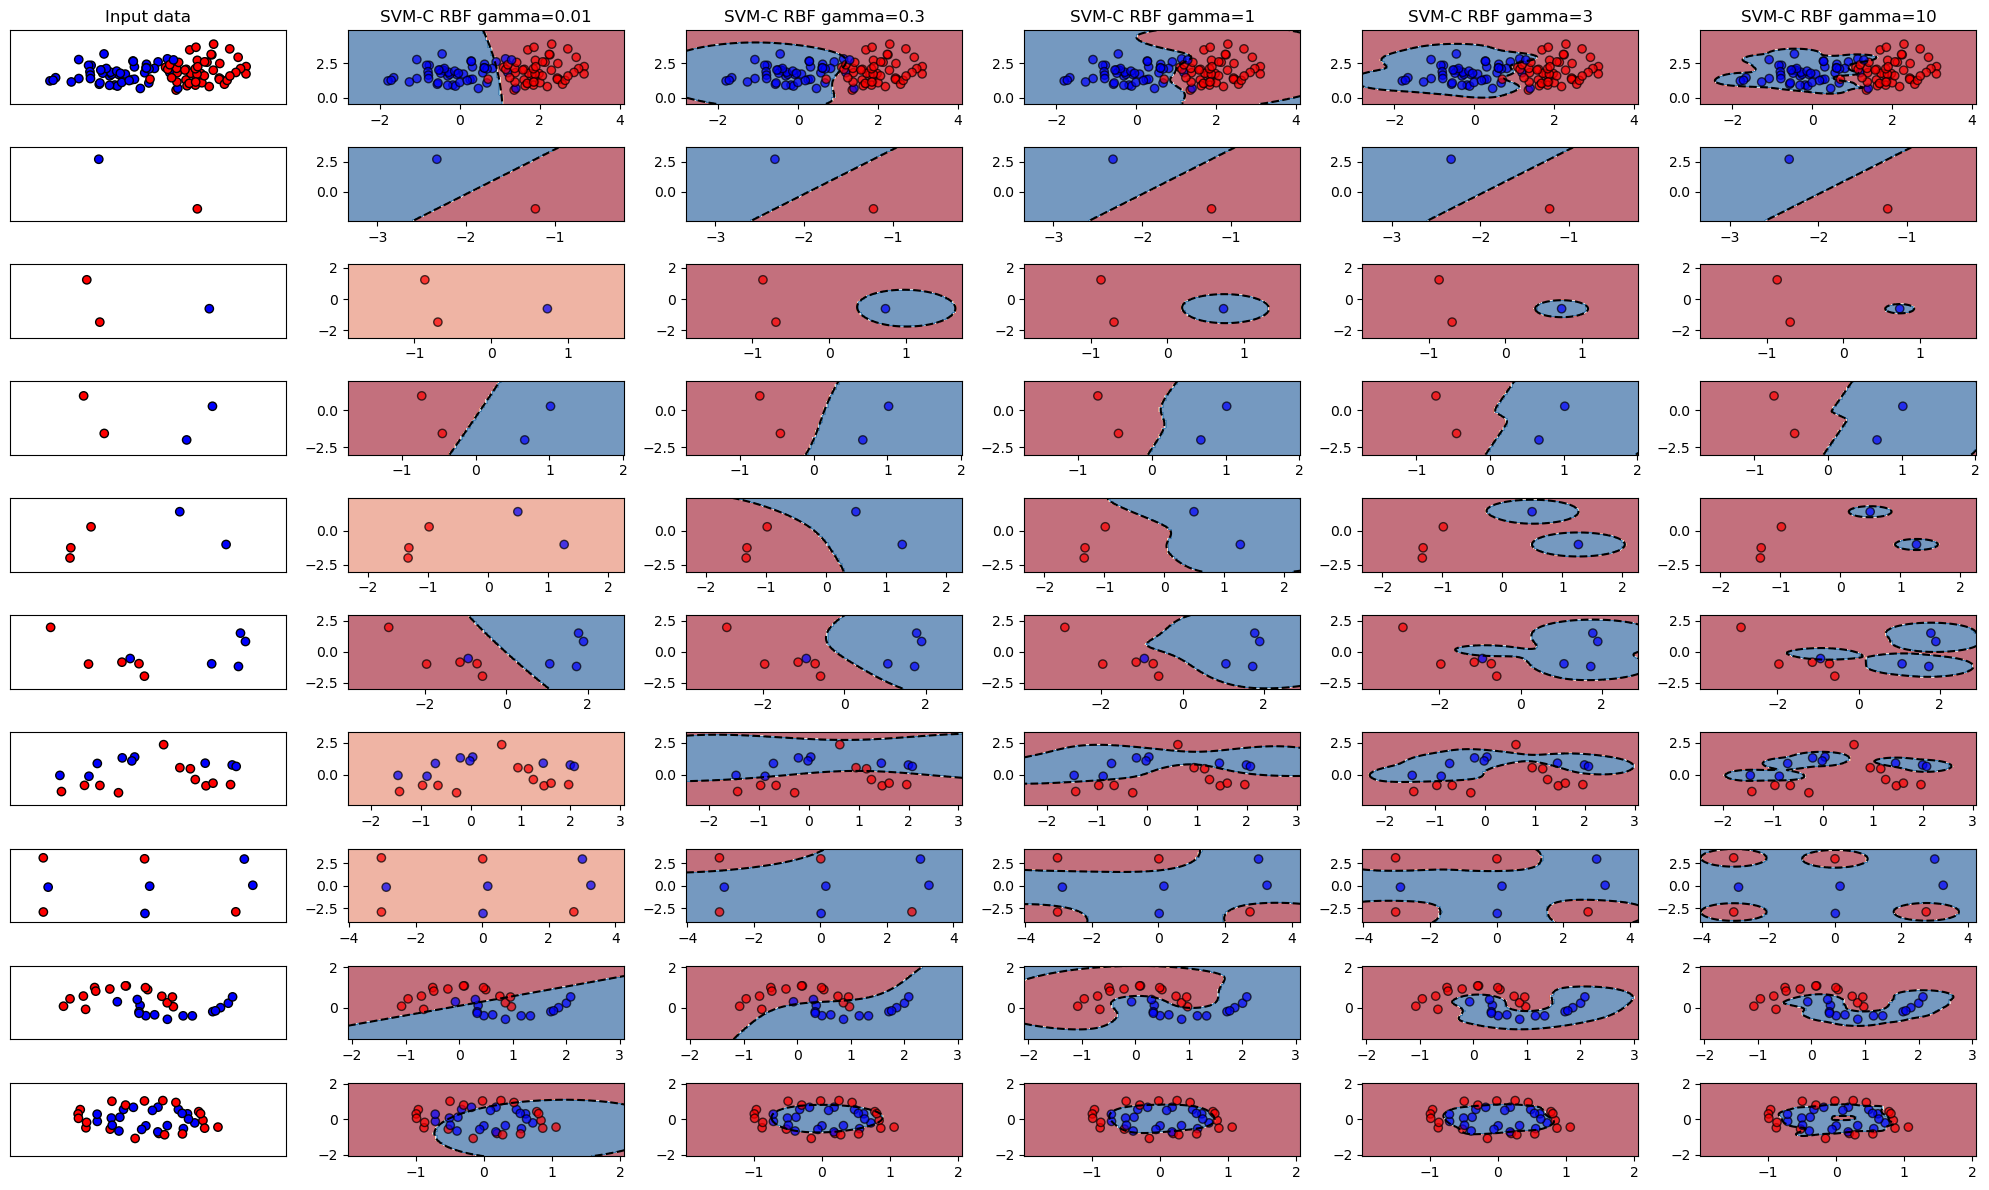

In [34]:
default_plotter(datasets, names, classifiers, plot_dims=(20,12))

#### How does regularization parameter C affect the margins?

A larger value of C results in a narrower margin and stricter classification, while a smaller value of C allows for a larger margin and more misclassification.

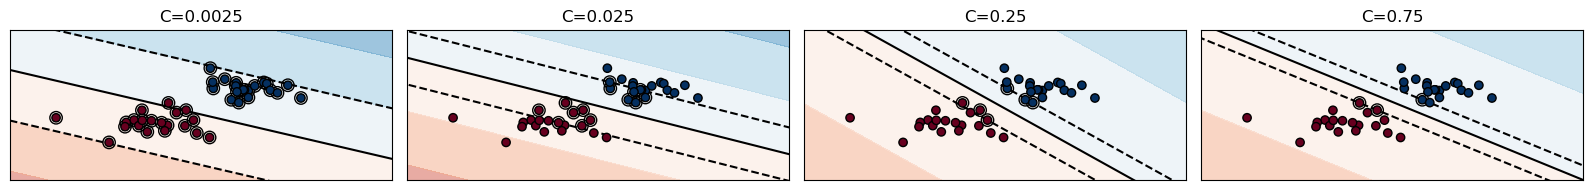

In [35]:
# Code source: Gaël Varoquaux
# Modified by Vladimir Lazarik
# License: BSD 3 clause

    # Setting the configurations
options = [("C=0.0025", 0.0025), ("C=0.025", 0.025), ("C=0.25", 0.25), ("C=0.75", 0.75)]

# Generate data
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20
figure = plt.figure(figsize=(20,2))

fignum = 1


for name, penalty in options:
    ax = plt.subplot(1, len(options) + 1, fignum)
    clf = SVC(kernel="linear", C=penalty)
    clf.fit(X, Y)

    # separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-12, 12)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot margins away from hyperplane in direction
    # perpendicular to hyperplane. This is sqrt(1+a^2) away vertically.
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin


    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")

    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
    )
    plt.scatter(
        X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.get_cmap("RdBu"), edgecolors="k"
    )

    plt.axis("tight")
    x_min = -6
    x_max = 6
    y_min = -8
    y_max = 8

    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Put the result into a contour plot
    plt.contourf(XX, YY, Z, cmap=plt.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    
    fignum = fignum + 1
    
plt.tight_layout()
plt.show()